# Results
This script uses data from cases that have output in chronological order and creates a time series figure

## Import modules

In [1]:
import sys
sys.path.append('/glade/u/home/adamhb/Earth-System-Model-Tools')
import os
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
from datetime import datetime#,timedelta
import esm_tools
from matplotlib import pyplot as plt
import seaborn as sns
import xarray as xr
pd.set_option('display.max_rows', 500)
import importlib
from vln import vln
importlib.reload(esm_tools)
from fields import fields
import glob
import string
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Functions

In [2]:
def load_multiple_ts(path,pattern,tags,tag_map,group_name="pre-restoration"):
    print("Loading data for these tags:",tags)
    paths = glob.glob(os.path.join(path,f"{pattern}*"))
    print(paths)
    ts_data = pd.DataFrame()
    for f in paths:
        tmp = load_processed_data(f,tags)
        ts_data = pd.concat([ts_data,tmp.reset_index()],axis = 0)
    #ts_data = ts_data.fillna(0)
    
    # add harmonized tag
    ts_data['harmonized_tag'] = ts_data['inst_tag'].map(tag_map)
    ts_data['group'] = group_name
    
    return ts_data.reset_index()


def load_processed_data(path,tags):    
    '''
    Load time-averaged metrics csv file (e.g. met_peas_path)
    '''
    
    raw_cols = pd.read_csv(path).columns
    if "Date" in raw_cols:
        #print("parsing date")
        d = drop_unnamed_columns(pd.read_csv(path,parse_dates=["Date"]))
    else:
        d = drop_unnamed_columns(pd.read_csv(path))

    # in case the above didn't parse as datetime
    #dates = [datetime.strptime(date,'%Y-%m-%d %H:%M:%S') for date in d['Date']]
    #d['Date'] = dates
    
    
    if "inst_tag" in d.columns:
        #d['inst_tag'] = esm_tools.inst_to_tag(d['inst_tag'])
        d = d.loc[d['inst_tag'].isin(tags)]

    d['VCD'] = d['AGCD'] * 1.4
    
    for var in ['Burned_area','Pct_conifer_cover_canopy','Pct_shrub_cover_canopy',
                'Pct_shrub_cover',
                'Pct_oak_cover_canopy','Pct_pine_cover_canopy',
                'Pct_cedar_cover_canopy','Pct_fir_cover_canopy']:
        d[var] = d[var] * 100

    all_vars = list(d.columns)
    for var in all_vars:
        if ("mort" in var) and ("per_cap" in var):
            d[var] = d[var] * 12 * 100
    
    return d

def path2output(dir):
    return os.path.join(processed_output_path,dir)

def get_fire_mort(case_name,
                  years,
                  pft_index,
                  tag_numbers,
                  dbh_min = 0,
                  var = 'FATES_MORTALITY_FIRE_SZPF'):
    '''
    Tags numbers should be a list of integers
    '''
    #tag_numbers = [2,  8, 14, 15, 22, 24, 25, 26, 30, 33, 46, 48, 50, 51, 52]
    inst_tags = esm_tools.inst_to_tag(tag_numbers) 
    output = pd.DataFrame()
    
    for inst_tag in inst_tags:
        ds = esm_tools.load_fates_output_data(model_output_root='/glade/derecho/scratch/adamhb',
                                    case_name = case_name,
                                    years = years,
                                    fields = fields,
                                    inst_tag = inst_tag,
                                    manual_path = None)

    
        fire_mort_n_per_m2_yr = esm_tools.scpf_to_scls_by_pft(ds[var], ds).mean(dim = "time").\
                     isel(fates_levpft = pft_index).sel(fates_levscls = slice(dbh_min,None))

        density = esm_tools.scpf_to_scls_by_pft(ds['FATES_NPLANT_SZPF'], ds).mean(dim = "time").\
                     isel(fates_levpft = pft_index).sel(fates_levscls = slice(dbh_min,None))

        fire_mort_n_per_capita_per_year = fire_mort_n_per_m2_yr / density
        
        #.sum(dim = 'fates_levpft')
        
        size_class = fire_mort_n_per_capita_per_year.fates_levscls
        vals = fire_mort_n_per_capita_per_year.values
        tmp = pd.DataFrame({'size_class':size_class,'mort':vals})
        tmp['inst_tag'] = inst_tag
        output = pd.concat([output,tmp],axis = 0)

    plt.rc('font', size=12)
    # Creating the box and whisker plot
    sns.boxplot(x='size_class', y='mort', data=output)


    # Adding titles and labels (optional)
    plt.title('{} fire mortality {}-{}'.format(pft_names[pft_index],years[0],years[1]))
    plt.xlabel('Size Class [cm dbh]')
    plt.ylabel('Mort rate [per capita yr-1]')
    
    # Display the plot
    plt.show()
    
    #return output

def date_convert(date_string):
    date_format = "%Y-%m-%d"
    # Convert the string to a datetime object
    datetime_object = datetime.strptime(date_string, date_format)
    return datetime_object



def metrics_diff(df1,df2):
    '''
    Get the ensemble-level differences between two metrics files (metrics file example = met_peas_path)
    '''
    if df1.shape != df2.shape:
        raise ValueError("Dataframe are not the same shape")

    if not list(df1['inst_tag']) == list(df2['inst_tag']):
        raise ValueError("Tags are not the same")

    tags = list(df1['inst_tag'])
    col_headers = list(df1.drop(columns = 'inst_tag').columns)

    end_means = df1.select_dtypes(exclude=['object']).mean(axis = 0,skipna=True)
    end_std = df1.select_dtypes(exclude=['object']).std(axis = 0,skipna=True)
    start_means = df2.select_dtypes(exclude=['object']).mean(axis = 0,skipna=True)
    start_std = df2.select_dtypes(exclude=['object']).std(axis = 0,skipna=True)
    
    data1 = df1.drop(columns = 'inst_tag').values
    data2 = df2.drop(columns = 'inst_tag').values

    delta = data1 - data2
    delta = pd.DataFrame(delta,columns=col_headers)
    delta_mean = delta.select_dtypes(exclude=['object']).mean(axis = 0,skipna=True)
    delta_std = delta.select_dtypes(exclude=['object']).std(axis = 0,skipna=True)
    
    pct_change = (data1 - data2) / data2 * 100
    threshold = 10000000
    pct_change[pct_change > threshold] = 0 # Replace values larger than the threshold with zero
    pct_change = np.nan_to_num(pct_change, nan=np.nan)
    pct_change = pd.DataFrame(pct_change,columns=col_headers)
    pct_change_mean = pct_change.select_dtypes(exclude=['object']).mean(axis = 0,skipna=True)
    pct_change_std = pct_change.select_dtypes(exclude=['object']).std(axis = 0,skipna=True)

    out = pd.DataFrame({'start':start_means,'start_sd':start_std,'end':end_means,'end_sd':end_std,
                        'delta':delta_mean,'delta_sd':delta_std,'pct_change':pct_change_mean,'pct_change_sd':pct_change_std})
    
    #out['inst_tag'] = tags
    #out = out[df1.columns]
    
    return out

def drop_unnamed_columns(df):
    # Get the list of column names
    column_names = df.columns
    
    # Filter the column names that contain "Unnamed"
    unnamed_columns = [col for col in column_names if 'Unnamed' in col]
    
    # Drop the unnamed columns from the DataFrame
    df = df.drop(columns=unnamed_columns)
    
    return df

def drop_first_col(d):
    return d.drop(d.columns[0], axis=1)

def get_basename_wo_exnt(full_path):
    return os.path.splitext(os.path.basename(full_path))[0]




def prep_comparison_data(input_list_of_dfs):

    list_of_dfs = []
    
    for i in range(len(input_list_of_dfs)):
        tmp = input_list_of_dfs[i].copy()
        tmp['scenario'] = scenarios[i]
        list_of_dfs.append(tmp)
    
    ts_data = pd.concat(list_of_dfs,axis = 0, ignore_index=True)
    return ts_data

def get_mean_and_std_ts(ts_data,var,group):
        ts_data = ts_data.copy()
        ts_data = ts_data.loc[ts_data['group'] == group]
        mean_values = ts_data.groupby("Date")[var].mean().reset_index()
        std_values = ts_data.groupby("Date")[var].std()
        mean_values['std'] = std_values.values
        return mean_values
        

def add_running_mean_time_window(df,time_window = 144):
    df = df.copy()
    df = df.set_index('Date').rolling(window = time_window).mean()
    return df.reset_index()

def HistModelObs(modData,Obs,Var):
    '''
    Returns a histogram comparing the model data to a range of observations

    Inputs:
    - modData: dataframe of model metrics
    - Obs: dictionary of observations from the literature. Each list is a range of a particular observation
    - Var: variable name to plot

    Output:
    - histogram
    '''
    var_data = modData[Var]
    
    if Var in ['Pct_shrub_cover_canopy','Burned_area']:
        var_data = var_data * 100
        
    n, bins, patches = plt.hist(var_data, bins=15, alpha=0.9, color='white', edgecolor='black', label = "Model")
    line1 = plt.axvline(x=Obs[Var][0], color='black', linestyle='--', linewidth=2, label = "Obs. range")
    line2 = plt.axvline(x=Obs[Var][1], color='black', linestyle='--', linewidth=2)
    plt.xlabel(vln[Var])
    plt.ylabel("Number of ensemble members")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Constants

In [52]:
m2_per_ha = 10000
group_colors = ['black','blue','red','green']
pft_names = ['pine','cedar','fir','shrub','oak']
subplot_labels = list(string.ascii_lowercase)
group_linetypes = ['-','-','dotted','dotted']
my_font_size = 35
my_num_cols = 2
num_cols = my_num_cols
figOut = '/glade/u/home/adamhb/california-fates/figures/'


vln = {'Burned_area':'Burned area [% yr-1]',
       'Pct_high_severity_3500':'High severity fire \n [% of fire > 3500 kW m-1]',
       'Pct_high_severity_1700':'High severity fire \n [% of fire > 1700 kW m-1]',
       'Pct_high_severity_1025':'High severity fire \n [% of fire > 1025 kW m-1]',
       'Pct_high_severity_2600':'High severity fire \n [% of fire > 2600 kW m-1]',
       'AWFI':'Area-weighted fire intensity [kW m-1]',
       'AGCD':'Above-ground carbon density [Kg C m-2]',
       'BA_conifer':'Conifer basal area \n [m-2 ha-1]',
       'Pct_shrub_cover_canopy':'Shrub cover in canopy [%]',
       'Pct_shrub_cover':'Total shrub cover [%]',
       'VCD':'Vegetation carbon density \n [Kg C m-2]',
       'Pct_conifer_cover_canopy':'Conifer cover [%]',
       'Pct_oak_cover_canopy':'Oak cover [%]',
       'Pct_pine_cover_canopy':'Pine cover [%]',
       'Pct_cedar_cover_canopy':'Cedar cover [%]',
       'Pct_fir_cover_canopy':'Fir cover [%]',
       'BA_pine':'Pine basal area (dbh > 10 cm) [m-2 ha-1]',
       'BA_cedar':'Cedar basal area (dbh > 10 cm) [m-2 ha-1]',
       'BA_fir':'Fir basal area (dbh > 10 cm) [m-2 ha-1]',
       'BA_oak':'Oak  basal area \n [m-2 ha-1]',
       'TreeStemD':'Tree Stem Density \n [N ha-1] \n (> 10 cm dbh)',
       'Combustible_fuel':'Combustible fuel \n [Kg C m-2]',
       'NPP':'NPP [KgC m-2 yr-1]',
       'mort_pine_fire_per_cap':'Pine fire mort \n [per capita (%) yr-1]',
       'mort_pine_cstarve_per_cap':'Pine cstarve mort \n [per capita (%) yr-1]',
       'mort_pine_hydr_per_cap':'Pine hydr failure mort \n [per capita (%) yr-1]',
       'mort_cedar_fire_per_cap':'Cedar fire mort \n [per capita (%) yr-1]',
       'mort_cedar_cstarve_per_cap':'Cedar cstarve mort \n [per capita (%) yr-1]',
       'mort_cedar_hydr_per_cap':'Cedar hydr failure mort \n [per capita (%) yr-1]',
       'mort_fir_fire_per_cap':'Fir fire mort \n [per capita (%) yr-1]',
       'mort_fir_cstarve_per_cap':'Fir cstarve mort \n [per capita (%) yr-1]',
       'mort_fir_hydr_per_cap':'Fir hydr failure mort \n [per capita (%) yr-1]',
       'mort_shrub_fire_per_cap':'Shrub fire mort \n [per capita (%) yr-1]',
       'mort_shrub_cstarve_per_cap':'Shrub cstarve mort \n [per capita (%) yr-1]',
       'mort_shrub_hydr_per_cap':'Shrub hydr failure mort \n [per capita (%) yr-1]',
       'mort_oak_fire_per_cap':'Oak fire mort [per capita \n (%) yr-1]',
       'mort_oak_cstarve_per_cap':'Oak cstarve mort \n [per capita (%) yr-1]',
       'mort_oak_hydr_per_cap':'Oak hydr failure mort \n [per capita month-1]',
       'SMP':'Soil matric potential \n [MPa 0.4 m depth]',
       'StemD10_pine':'Pine stem density \n [N ha-1] \n (> 10 cm dbh)',
       'mort_pine_fire_n_per_ha':'Pine fire mort \n [N ha-1 month-1]',
       'Rec_pine':'Pine recruitment \n (0.7 m height) \n [N ha-1 yr -1]',
       'Rec_cedar':'Cedar recruitment \n (0.7 m height) \n [N ha-1 yr -1]',
       'Rec_fir':'Fir recruitment \n (0.7 m height) \n [N ha-1 yr -1]',
       'Rec_shrub':'Shrub recruitment \n (0.7 m height) \n [N ha-1 yr -1]',
       'Rec_oak':'Oak recruitment \n (0.7 m height) \n [N ha-1 yr -1]'
       }

## Load data

In [4]:
processed_output_path = '/glade/work/adamhb/processed_output'

peas_tag_map = {42:1,61:2,66:3,74:4,76:5}
f1870_to_2015_tag_map = {41:1,60:2,65:3,73:4,75:5}
SSP3_TREATED_tag_map = f1870_to_2015_tag_map
SSP3_no_treat_tag_map = {41:1,60:2,64:3,72:4,74:5}

# Load timeseries data
peas_ts = load_multiple_ts(path2output('equilibrium_700yrs_050924_01'),pattern = 'ts_1830-1870',tags = list(peas_tag_map.keys()), tag_map=peas_tag_map)
f1870_2015_ts = load_multiple_ts(path2output('f1870_to_2015_051624'),pattern = 'ts_1870-2015',tags = list(f1870_to_2015_tag_map.keys()), tag_map=f1870_to_2015_tag_map)
benchmarking_ts = pd.concat([peas_ts,f1870_2015_ts])

SSP3_treated_ts = load_multiple_ts(path2output('SSP3_treated_051624'),pattern = 'ts_2015-2098',tags = list(SSP3_TREATED_tag_map.keys()), tag_map=SSP3_TREATED_tag_map, group_name="single_treatment")
SSP3_not_treated_ts = load_multiple_ts(path2output('SSP3_not_treated_051624'),pattern = 'ts_2015-2098',tags = list(SSP3_no_treat_tag_map.keys()), tag_map=SSP3_no_treat_tag_map, group_name="not_treated")
SSP3_continuous_treatment = load_multiple_ts(path2output('SSP3_continuous_treatment_052124'),pattern = 'ts_2015-2098',tags = list(SSP3_no_treat_tag_map.keys()), tag_map=SSP3_no_treat_tag_map, group_name="continuous_treatment")

full_ts = pd.concat([peas_ts,f1870_2015_ts,SSP3_treated_ts,SSP3_not_treated_ts,SSP3_continuous_treatment])

Loading data for these tags: [42, 61, 66, 74, 76]
['/glade/work/adamhb/processed_output/equilibrium_700yrs_050924_01/ts_1830-1870_0061.csv', '/glade/work/adamhb/processed_output/equilibrium_700yrs_050924_01/ts_1830-1870_0074.csv', '/glade/work/adamhb/processed_output/equilibrium_700yrs_050924_01/ts_1830-1870_0076.csv', '/glade/work/adamhb/processed_output/equilibrium_700yrs_050924_01/ts_1830-1870_0042.csv', '/glade/work/adamhb/processed_output/equilibrium_700yrs_050924_01/ts_1830-1870_0066.csv']
Loading data for these tags: [41, 60, 65, 73, 75]
['/glade/work/adamhb/processed_output/f1870_to_2015_051624/ts_1870-2015_0041.csv', '/glade/work/adamhb/processed_output/f1870_to_2015_051624/ts_1870-2015_0073.csv', '/glade/work/adamhb/processed_output/f1870_to_2015_051624/ts_1870-2015_0060.csv', '/glade/work/adamhb/processed_output/f1870_to_2015_051624/ts_1870-2015_0065.csv', '/glade/work/adamhb/processed_output/f1870_to_2015_051624/ts_1870-2015_0075.csv']
Loading data for these tags: [41, 60, 

### Observations

In [5]:
obs_PEAS = {'Burned_area':[3,11], #Range for burned area was calculated from the FRI estimates given in Table 3 of Williams et al., 2023. BurnFrac = 1/ FRI. The ranges given in Safford and Stevens, 2017 are larger.
       'Pct_high_severity_3500':[1,6], # Williams+ 2023; Safford and Stevens, 2017, Stephens+ 2015
       'Pct_high_severity_1700':[1,6],# Williams+ 2023; Safford and Stevens, 2017, Stephens+ 2015
       'Pct_high_severity_2600':[1,6],# Williams+ 2023; Safford and Stevens, 2017, Stephens+ 2015
       'BA_conifer':[10.6,55], #10 cm min dbh; USDA FS 1911 (21); Scholl & Taylor, 2010 (29.5); Collins et al., 2015 (DRY sits within the landscape analysis; min:10.6); Stephens et al., 2015; Safford & Stevens, 2017; Knapp et al., 2012 (max: 55)
       'Pct_shrub_cover_canopy':[9,54], # Show & Kotok, 1924; Bonnicksen & Stone, 1982; Cronemiller, 1959; Knapp et al., 2013; Collins et al., 2015; Stephens et al., 2015; Safford & Stevens, 2017
       'Pct_shrub_cover':[9,54],# Show & Kotok, 1924 (11); Bonnicksen & Stone, 1982 (19); Cronemiller, 1959; Knapp et al., 2013; Collins et al., 2015; Stephens et al., 2015; Safford & Stevens, 2017
       'TreeStemD':[60,320] # Safford and Stevens, 2017 Fig 14     
      }
obs_SUP = {'Burned_area':[0.53487,2],# Williams+ 2023 (low: 1980 to 2010, high: 2010 to 2020)
           'Pct_high_severity_2600':[20,30], # Williams+ 2023 (low: 1980 to 2020 value - 20%; high 1980 to 2020 value + 20%
           'BA_conifer':[15.6,69.4],#10 cm min dbh; Knapp et al., 2012; Scholl & Taylor, 2010 (max: 69.4); Collins et al., 2015; Stephens et al., 2015 (min: 15.6; dbh min = ~30 cm); Safford & Stevens, 2017; Buotte et al., 2021 (CZ2 census: 35 m2 ha-1)
           'Pct_shrub_cover_canopy':[2.5,22],#Knapp et al, 2015 (2.5); Wang et al., 2022 (22); Cronemiller et al., 1959 (14)
           'Pct_shrub_cover':[2.5,22],#Knapp et al, 2015 (2.5); Wang et al., 2022 (22); Cronemiller et al., 1959 (14)
           'BA_oak':[0.7,3.02],# Buotte et al., 2021; Mean +- SD of variation across subplots at NEON SOAP for QUCH and QUKE
           'TreeStemD':[104,700], # Safford and Stevens, 2017; Fig 14    
           'NPP':[0.42,1]} #Tague et al., 2009; He et al., 2012; Goulden et al., 2012; Dore et al., 2016; Bogan et al., 2018

## Benchmarking Figure

/glade/u/home/adamhb/california-fates/figures/benchmarking.pdf


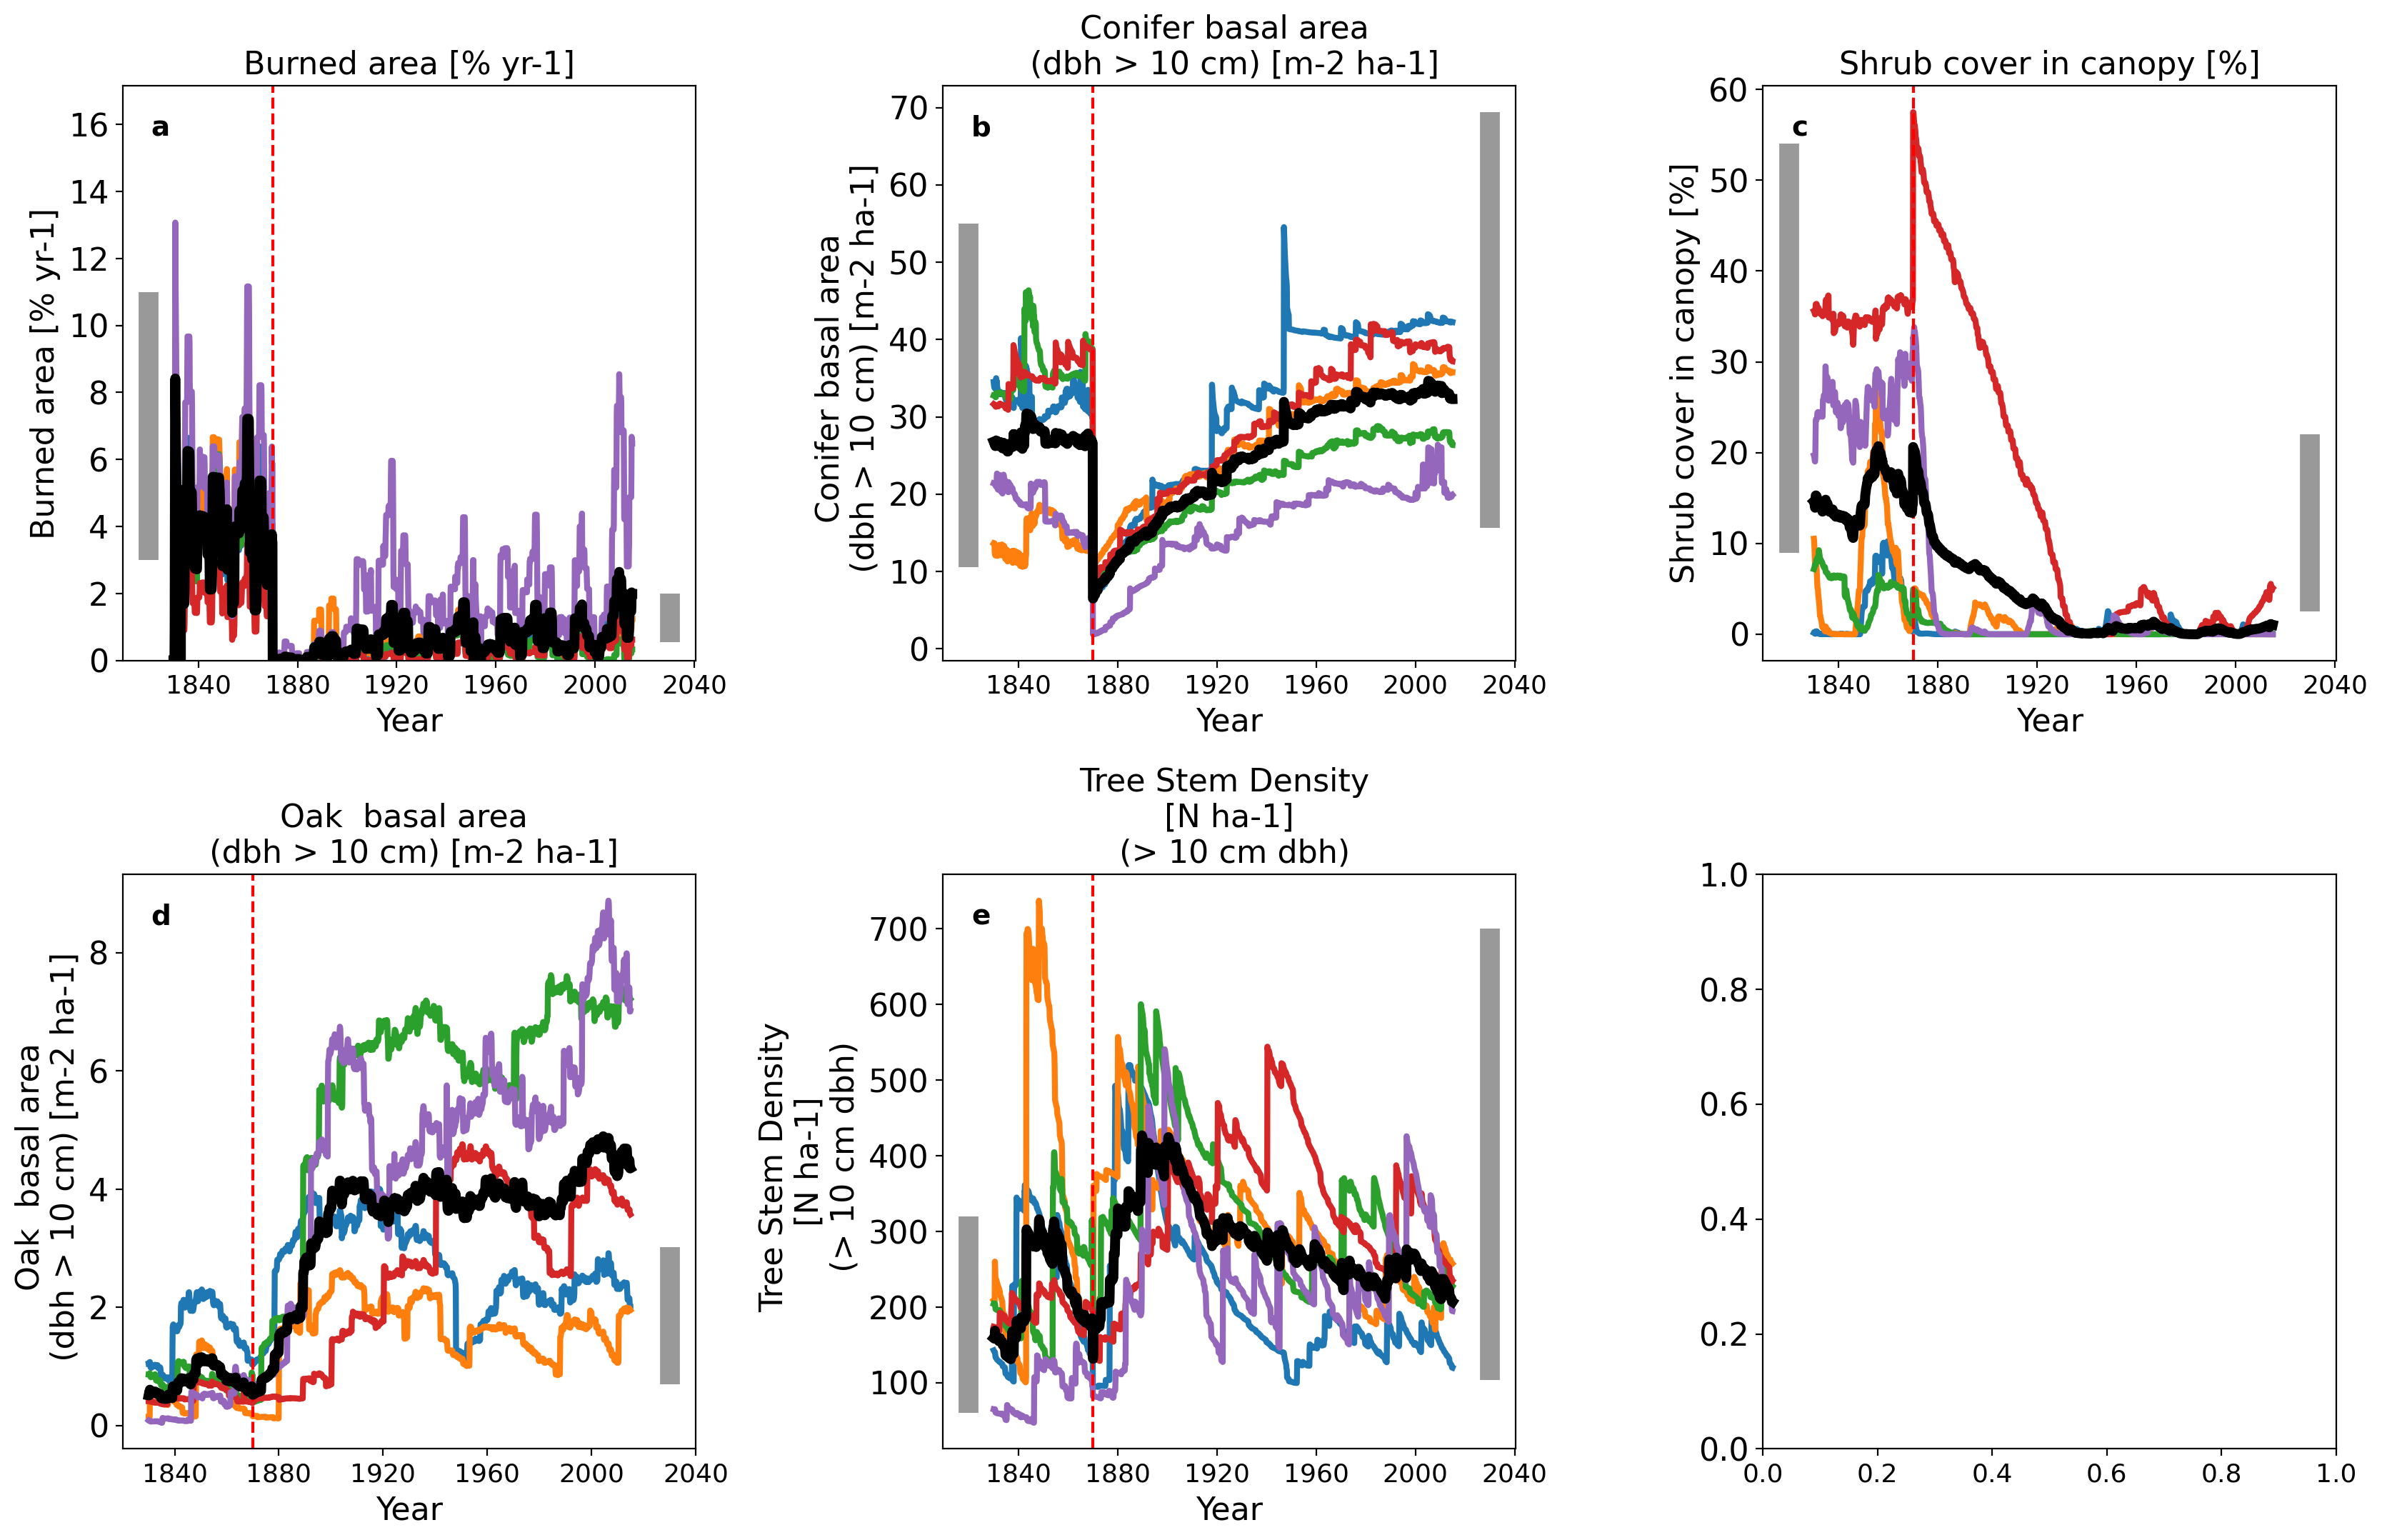

In [47]:
def make_ts_fig(ts_data,
                vars_to_plot,
                tags,
                start_date = None,
                end_date = None,
                group = "treated",
                figName = "fig", saveFig = False, add_obs = True, make_legend = False):


    ts_font_size = 14
    plt.rc('font', size=ts_font_size)
    
    # Filter
    ts_data = ts_data.copy()
    if (start_date != None) & (end_date != None):
        ts_data = ts_data.loc[(ts_data['Date'] >= date_convert(start_date)) & (ts_data['Date'] <= date_convert(end_date))]
    
    ts_data = ts_data.loc[ts_data['group'] == group]
    ts_data = ts_data.loc[ts_data['harmonized_tag'].isin(tags)]
    #ts_data['NPP_rolling'] = ts_data['NPP'].rolling(window=360).mean()
    ts_data_PHS = ts_data.dropna().copy()

    # Calculate the number of rows needed for subplots
    num_rows = (len(vars_to_plot) + my_num_cols - 1) // my_num_cols
    
    # Years to add to timeline
    year_1870 = datetime(1870, 1, 1)
    year_PEAS_obs = datetime(1820, 1, 1)
    year_EAS_obs = datetime(2030,1,1)
    year_2015 = datetime(2015,1,1)

    
    plt.rc('font', size=ts_font_size)
    
    
    # Create a figure with subplots
    y_size_factor = 60/7
    y_size = y_size_factor * num_rows
    
    #fig, axes = plt.subplots(num_rows, my_num_cols, figsize=(12.5, 15), dpi=200, sharex=False)
    fig, axes = plt.subplots(2, 3, figsize=(17, 11), dpi=200, sharex=False)
    axes = axes.flatten()
    
    palette = sns.color_palette("tab10")[:5]  # or you can use "viridis", "plasma", "inferno", etc.
    
    # Loop through each variable and create a subplot
    for var_index, var in enumerate(vars_to_plot):

        ax = axes[var_index]
        fire_sev_var = ("Pct_high_sev" in var) | ("AWFI" in var)
    
        if fire_sev_var:
            sns.lineplot(x="Date", y=var, hue="harmonized_tag", markers="harmonized_tag",
                         data=ts_data_PHS, ax=ax, alpha = 1, linewidth = 3, estimator=None, palette=palette, legend = make_legend)
        else:
            sns.lineplot(x="Date", y=var, hue="harmonized_tag", markers="harmonized_tag",
                         data=ts_data, ax=ax, alpha = 1, linewidth = 3, estimator=None, palette=palette, legend = make_legend)

        if add_obs == True:
            if var in obs_PEAS.keys():
                ax.vlines(x=year_PEAS_obs, color="gray", linestyle="-", linewidth = 10, 
                          ymin = obs_PEAS[var][0], ymax = obs_PEAS[var][1], alpha = 0.8, label = "PEAS observations")
            if var in obs_SUP.keys():        
                ax.vlines(x=year_EAS_obs, color="gray", linestyle="-", linewidth = 10,
                          ymin = obs_SUP[var][0], ymax = obs_SUP[var][1], alpha = 0.8, label = "EAS observations")
    
        ax.set_title(vln[var])
        ax.set_ylabel(vln[var])
        ax.set_xlabel("Year")
        
        # Set plot title and labels
        if var == "Burned_area":
            ax.set_ylim(ymin=0)
        
        if min(ts_data['Date']) < year_1870:
            ax.axvline(x=year_1870, color="red", linestyle="--")
        if max(ts_data['Date']) > year_2015:
            ax.axvline(x=year_2015, color="green", linestyle="--")
        
        # Add ensemble mean
        if fire_sev_var:
           mean_values = ts_data_PHS.groupby("Date")[var].mean()
        else:
           mean_values = ts_data.groupby("Date")[var].mean()

        ax.plot(mean_values.index, mean_values.values, color="black", linestyle="-", label="Ensemble mean",linewidth = 5)
        ax.text(0.05, 0.95, subplot_labels[var_index], transform=ax.transAxes, fontsize=ts_font_size, fontweight='bold', va='top')

        if make_legend == True:
            # Add legend to first subplot
            # Manually create the legends
            from matplotlib.lines import Line2D
            harmonized_tags = ts_data_PHS['harmonized_tag'].unique()
            handles, labels = ax.get_legend_handles_labels()
            # Create custom legend handles with adjusted line width
            
            harmonized_handles = [Line2D([0], [0], color=palette[i], lw=4) for i in range(len(harmonized_tags))]  # Adjust lw to desired line width
            
            # Separate handles and labels for harmonized tags and the mean line
            mean_line = [handles.pop(labels.index('Ensemble mean'))]
            mean_label = [labels.pop(labels.index('Ensemble mean'))]
            
            # Add the mean line legend
            first_legend = ax.legend(mean_line, mean_label, loc='center left', bbox_to_anchor=(1, 0.25), title='')
            ax.add_artist(first_legend)
            
            # Add the harmonized tags legend
            second_legend = ax.legend(harmonized_handles, labels, loc='center left', bbox_to_anchor=(1, 0.75), title='Ensemble member')

        
    # Remove any empty subplots
    for i in range(len(vln.keys()), num_rows * my_num_cols):
        fig.delaxes(axes[var_index])
    
    # Adjust layout
    plt.tight_layout()

    if saveFig == True:
        figName = os.path.join(figOut,figName + '.pdf')
        print(figName)
        plt.savefig(figName)
    
    plt.show()

bench_metrics = ['Burned_area',#'Pct_high_severity_2600',
                 'BA_conifer','Pct_shrub_cover_canopy',
                 'BA_oak','TreeStemD']


make_ts_fig(benchmarking_ts,
            bench_metrics,
            [1,2,3,4,5],
            start_date = None,
            end_date = None,
            group = "pre-restoration",
            figName = "benchmarking", saveFig = True, add_obs = True, make_legend = False)

In [36]:
bench_metrics = ['Burned_area','BA_conifer']


make_ts_fig(benchmarking_ts,
            bench_metrics,
            [1,2,3,4,5],
            start_date = None,
            end_date = None,
            group = "pre-restoration",
            figName = "benchmarking", saveFig = True, add_obs = True, make_legend = False)

0      1830-01-01
1      1830-02-01
2      1830-03-01
3      1830-04-01
4      1830-05-01
          ...    
5035   2098-08-01
5036   2098-09-01
5037   2098-10-01
5038   2098-11-01
5039   2098-12-01
Name: Date, Length: 26220, dtype: datetime64[ns]

## Model experiment results

In [53]:
def compare_ts(ts_data,
               vars_to_plot,
               tags,
               start_date = None,
               end_date = None,
               figName = "fig",
               saveFig = False,
               add_obs = True, ymin = None, ymax = None):

    subplot_labels = list(string.ascii_lowercase)
    ts_data = ts_data.copy()

    # Filter by date
    if (start_date != None) & (end_date != None):
        ts_data = ts_data.loc[(ts_data['Date'] >= date_convert(start_date)) & (ts_data['Date'] <= date_convert(end_date))]
    
    # Filter by tag  
    ts_data = ts_data.loc[ts_data['harmonized_tag'].isin(tags)]
    ts_data_PHS = ts_data.dropna().copy()
    groups = ts_data['group'].unique()
    group_names_dict = {'pre-restoration':'pre-treatment','single_treatment':'single treatment','not_treated':'not treated','continuous_treatment':'continuous treatment'}
    group_names = [group_names_dict[i] for i in groups]
    member_names = ['M1','M2','M3','M4','M5']
    
    # Calculate the number of rows needed for subplots
    num_rows = len(vars_to_plot)
    
    # Years to add to timeline
    year_1870 = datetime(1870, 1, 1)
    year_PEAS_obs = datetime(1832, 1, 1)
    year_EAS_obs = datetime(2014,1,1)
    year_2015 = datetime(2015,1,1)
    

    f = 16
    
    plt.rcParams['font.size'] = f  # sets the default font size for all text
    plt.rcParams['axes.titlesize'] = f  # font size for axes titles
    plt.rcParams['axes.labelsize'] = f  # font size for x and y labels
    plt.rcParams['xtick.labelsize'] = f-3  # font size for x tick labels
    plt.rcParams['ytick.labelsize'] = f  # font size for y tick labels
    
    # Create a figure with subplots
    
    fig, axes = plt.subplots(num_rows, len(tags), figsize=(15, 10), dpi=200, sharey="row")
    #fig, axes = plt.subplots(num_rows, len(tags), figsize=(15, 6), dpi=200, sharey="row")
    #fig, axes = plt.subplots(num_rows, len(tags), figsize=(7, 7), dpi=200, sharey="row")
    
    axes = axes.flatten()
    
    # Loop through each variable and create a subplot
    ax_i = -1
    for var_index, var in enumerate(vars_to_plot):
        fire_sev_var = ("Pct_high_sev" in var) | ("AWFI" in var)
        for t_index,t in enumerate(tags):
            ax_i = ax_i + 1
            ax = axes[ax_i]
            
            ts_data_1tag = ts_data.loc[ts_data['harmonized_tag'] == t]
            ts_data_PHS_1tag = ts_data_PHS.loc[ts_data_PHS['harmonized_tag'] == t]
            
            for i,s in enumerate(groups):
                
                if fire_sev_var:
                    plot_data = get_mean_and_std_ts(ts_data_PHS_1tag,var,groups[i])
                    plot_data['rolling_var'] = plot_data[var].rolling(window = 3).mean()
                    ax.plot(plot_data['Date'], plot_data['rolling_var'], color=group_colors[i], linewidth = 2.5, linestyle='-',label = group_names[i])
                    if i < 2:
                        ax.fill_between(plot_data['Date'], plot_data[var] - plot_data['std'], plot_data[var] + plot_data['std'], color=group_colors[i], alpha=0.06)
                       
                else:
                    plot_data = get_mean_and_std_ts(ts_data_1tag,var,groups[i])
                    if ('mort' in var) | ('SMP' in var) | ('NPP' in var) | ('Rec' in var):
                        plot_data = add_running_mean_time_window(plot_data)
                        #print("adding running mean")
                        #return plot_data
                    ax.plot(plot_data['Date'], plot_data[var], color=group_colors[i], linewidth = 2.5, linestyle='-',label = group_names[i])
                    if i < 2:
                        ax.fill_between(plot_data['Date'], plot_data[var] - plot_data['std'], plot_data[var] + plot_data['std'], color=group_colors[i], alpha=0.06)
                    
                    
    
            if add_obs == True:
                if var in obs_PEAS.keys():
                    ax.vlines(x=year_PEAS_obs, color="black", linestyle="-", linewidth = 10, 
                              ymin = obs_PEAS[var][0], ymax = obs_PEAS[var][1], alpha = 0.8, label = "PEAS observations")
                if var in obs_SUP.keys():        
                    ax.vlines(x=year_EAS_obs, color="skyblue", linestyle="-", linewidth = 10,
                              ymin = obs_SUP[var][0], ymax = obs_SUP[var][1], alpha = 0.8, label = "EAS observations")

            if ax_i < 5:
                ax.set_title(f'{member_names[t_index]}')
            else:
                ax.set_title('')
                

            if ax_i % 5 == 0:
                ax.set_ylabel(vln[var])
            else:
                ax.set_ylabel('')
                
            ax.set_xlabel("")
            ax.xaxis.set_major_locator(mdates.YearLocator(base=30))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            ax.text(0.05, 0.95, subplot_labels[ax_i], transform=ax.transAxes, fontweight='bold', va='top')
            
            # Set plot title and labels
            if var == "Burned_area":
                ax.set_ylim(ymin=0)
                ax.set_ylim(ymax=20)

            if ymin != None:
                ax.set_ylim(ymin=ymin)
                ax.set_ylim(ymax=ymax)
            
            if min(ts_data['Date']) < year_1870:
                ax.axvline(x=year_1870, color="red", linestyle="--")
            #if max(ts_data['Date']) > year_2015:
            #    ax.axvline(x=year_2015, color="green", linestyle="--")
        
            # if ax_i < 1:
            #     legend = ax.legend()
            #     for legobj in legend.legendHandles:
            #         legobj.set_linewidth(6.0)  # Set the line width
        
    # Remove any empty subplots
    for i in range(len(vln.keys()), num_rows * my_num_cols):
        fig.delaxes(axes[var_index])
    
    # Adjust layout
    plt.tight_layout(pad = 0.1)

    if saveFig == True:
        figName = os.path.join(figOut,figName + '.pdf')
        print(figName)
        plt.savefig(figName)
    
    plt.show()

/glade/u/home/adamhb/california-fates/figures/main.pdf


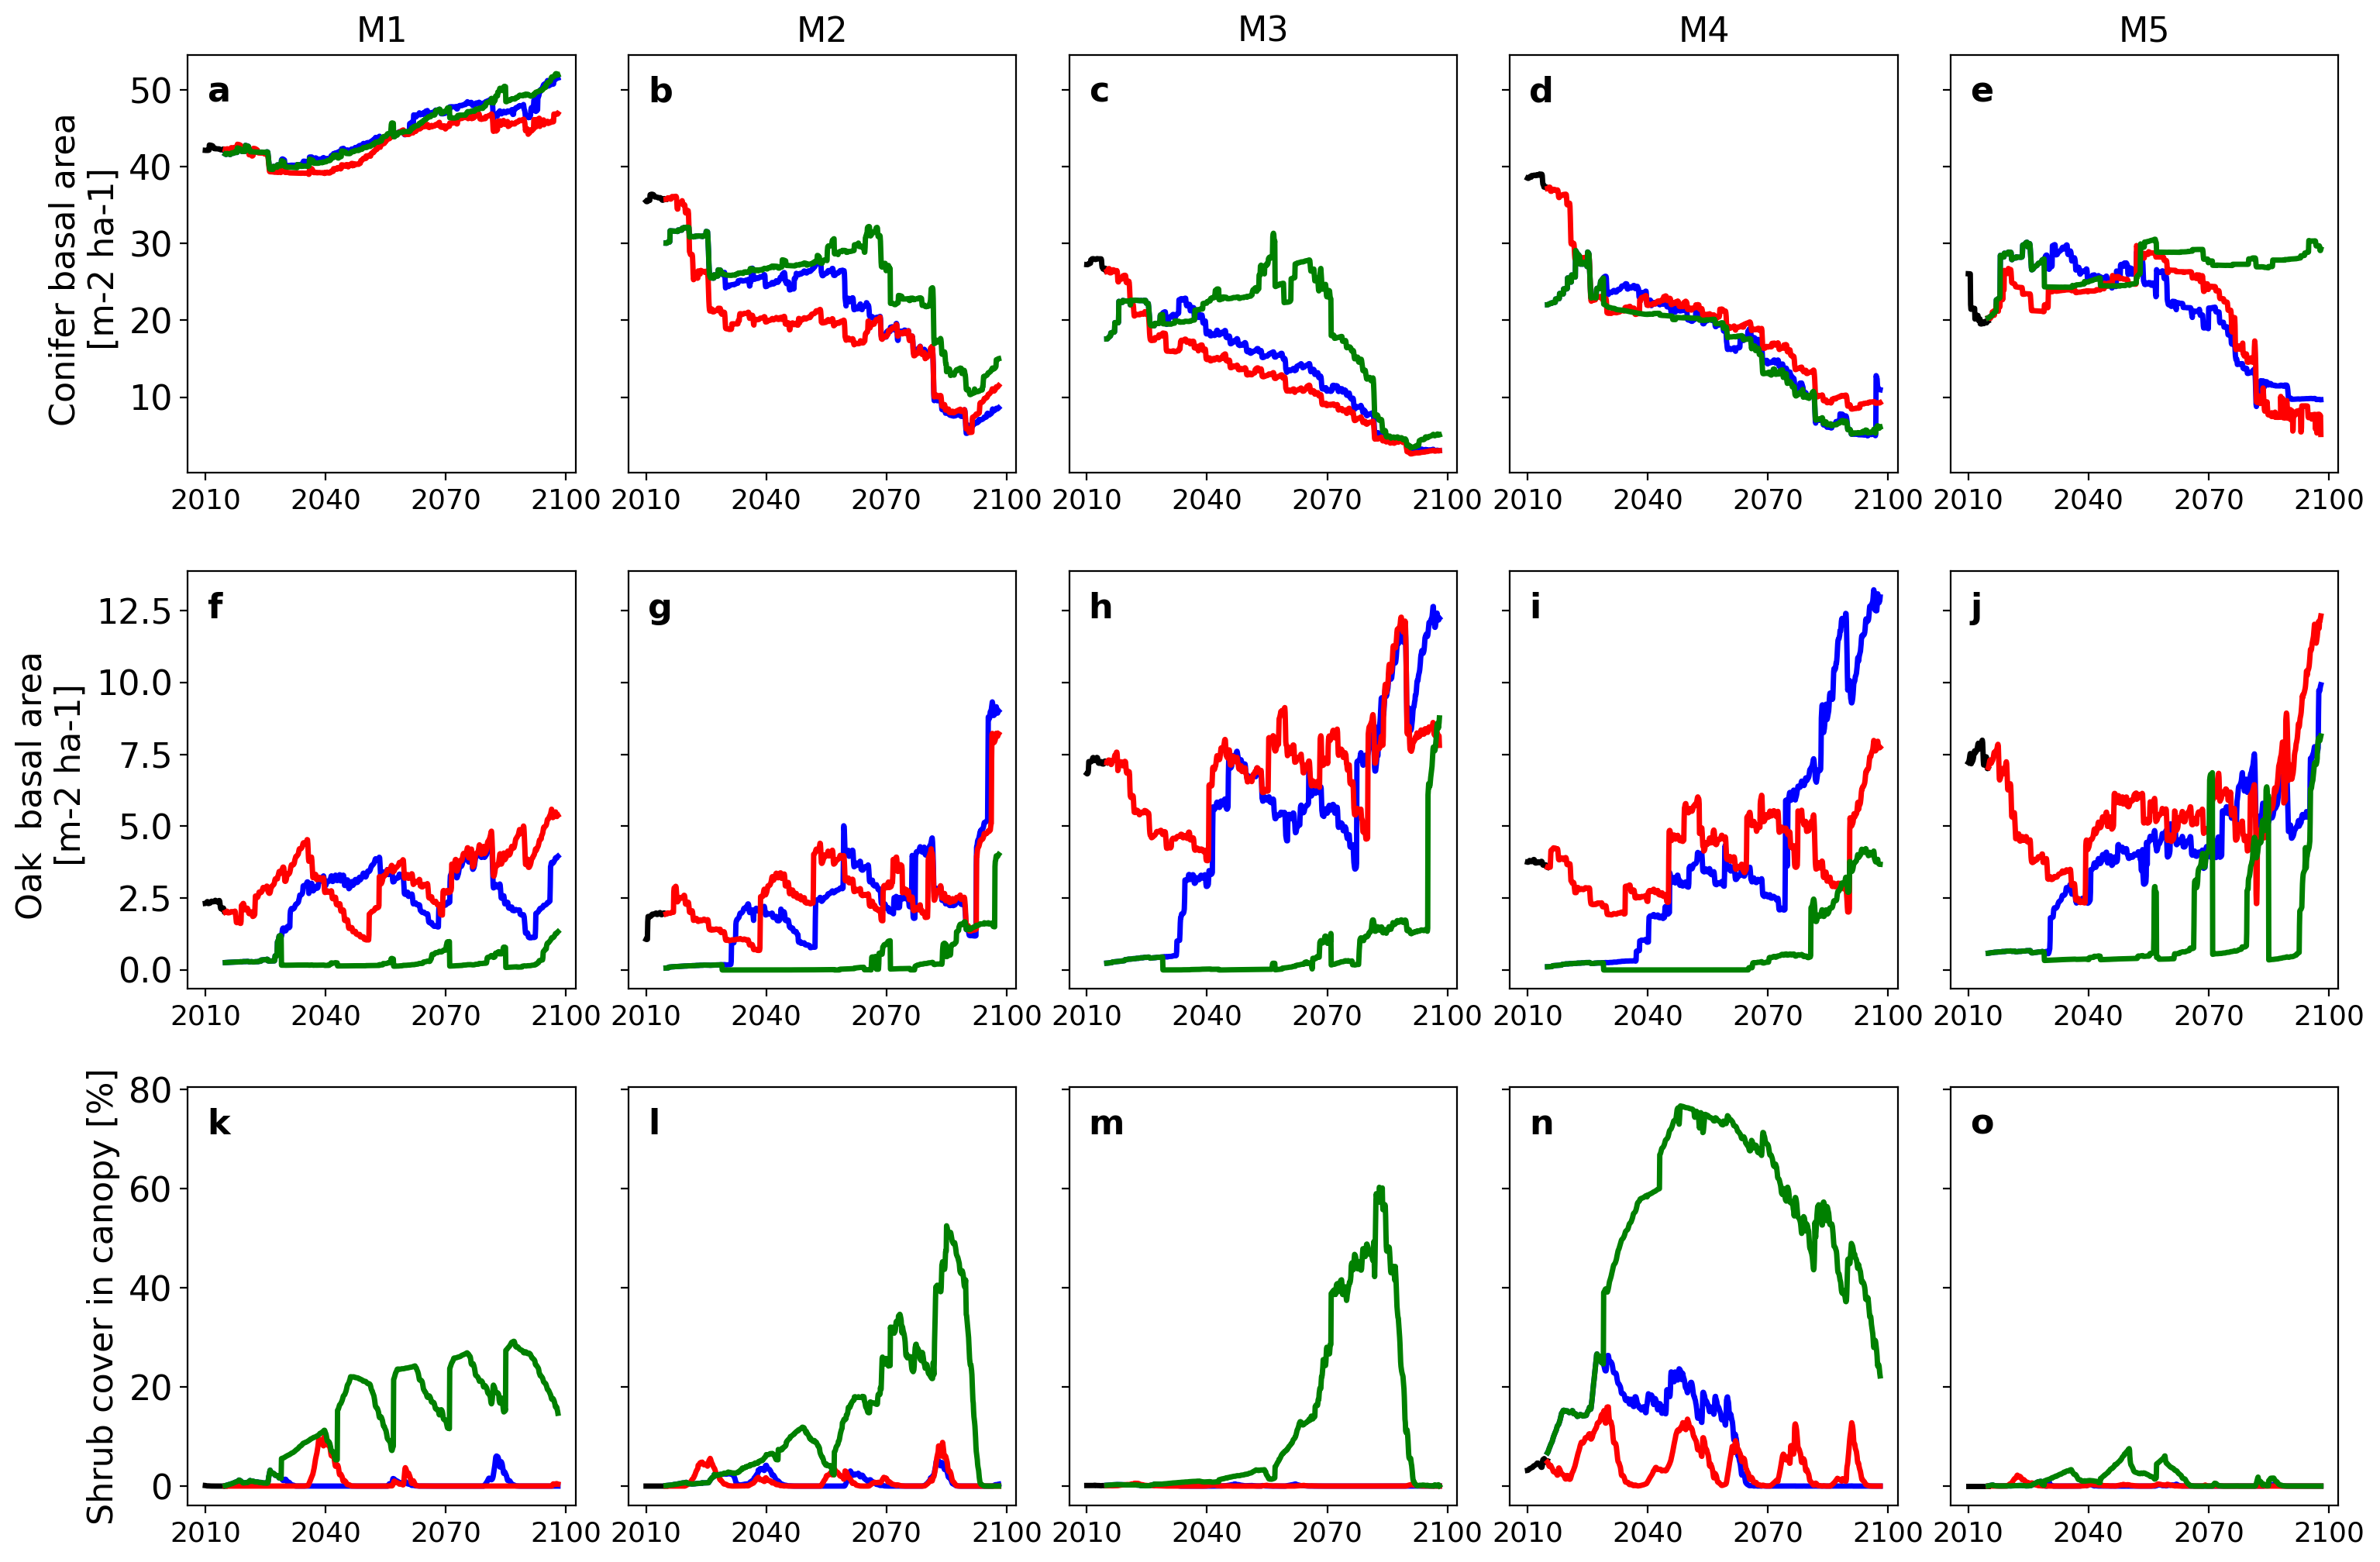

In [55]:
experimental_metrics = ['BA_conifer','BA_oak','Pct_shrub_cover_canopy']
compare_ts(full_ts,experimental_metrics,[1,2,3,4,5],"2010-01-01","2098-01-01",add_obs = False, figName = "main",saveFig=True)

/glade/u/home/adamhb/california-fates/figures/main.pdf


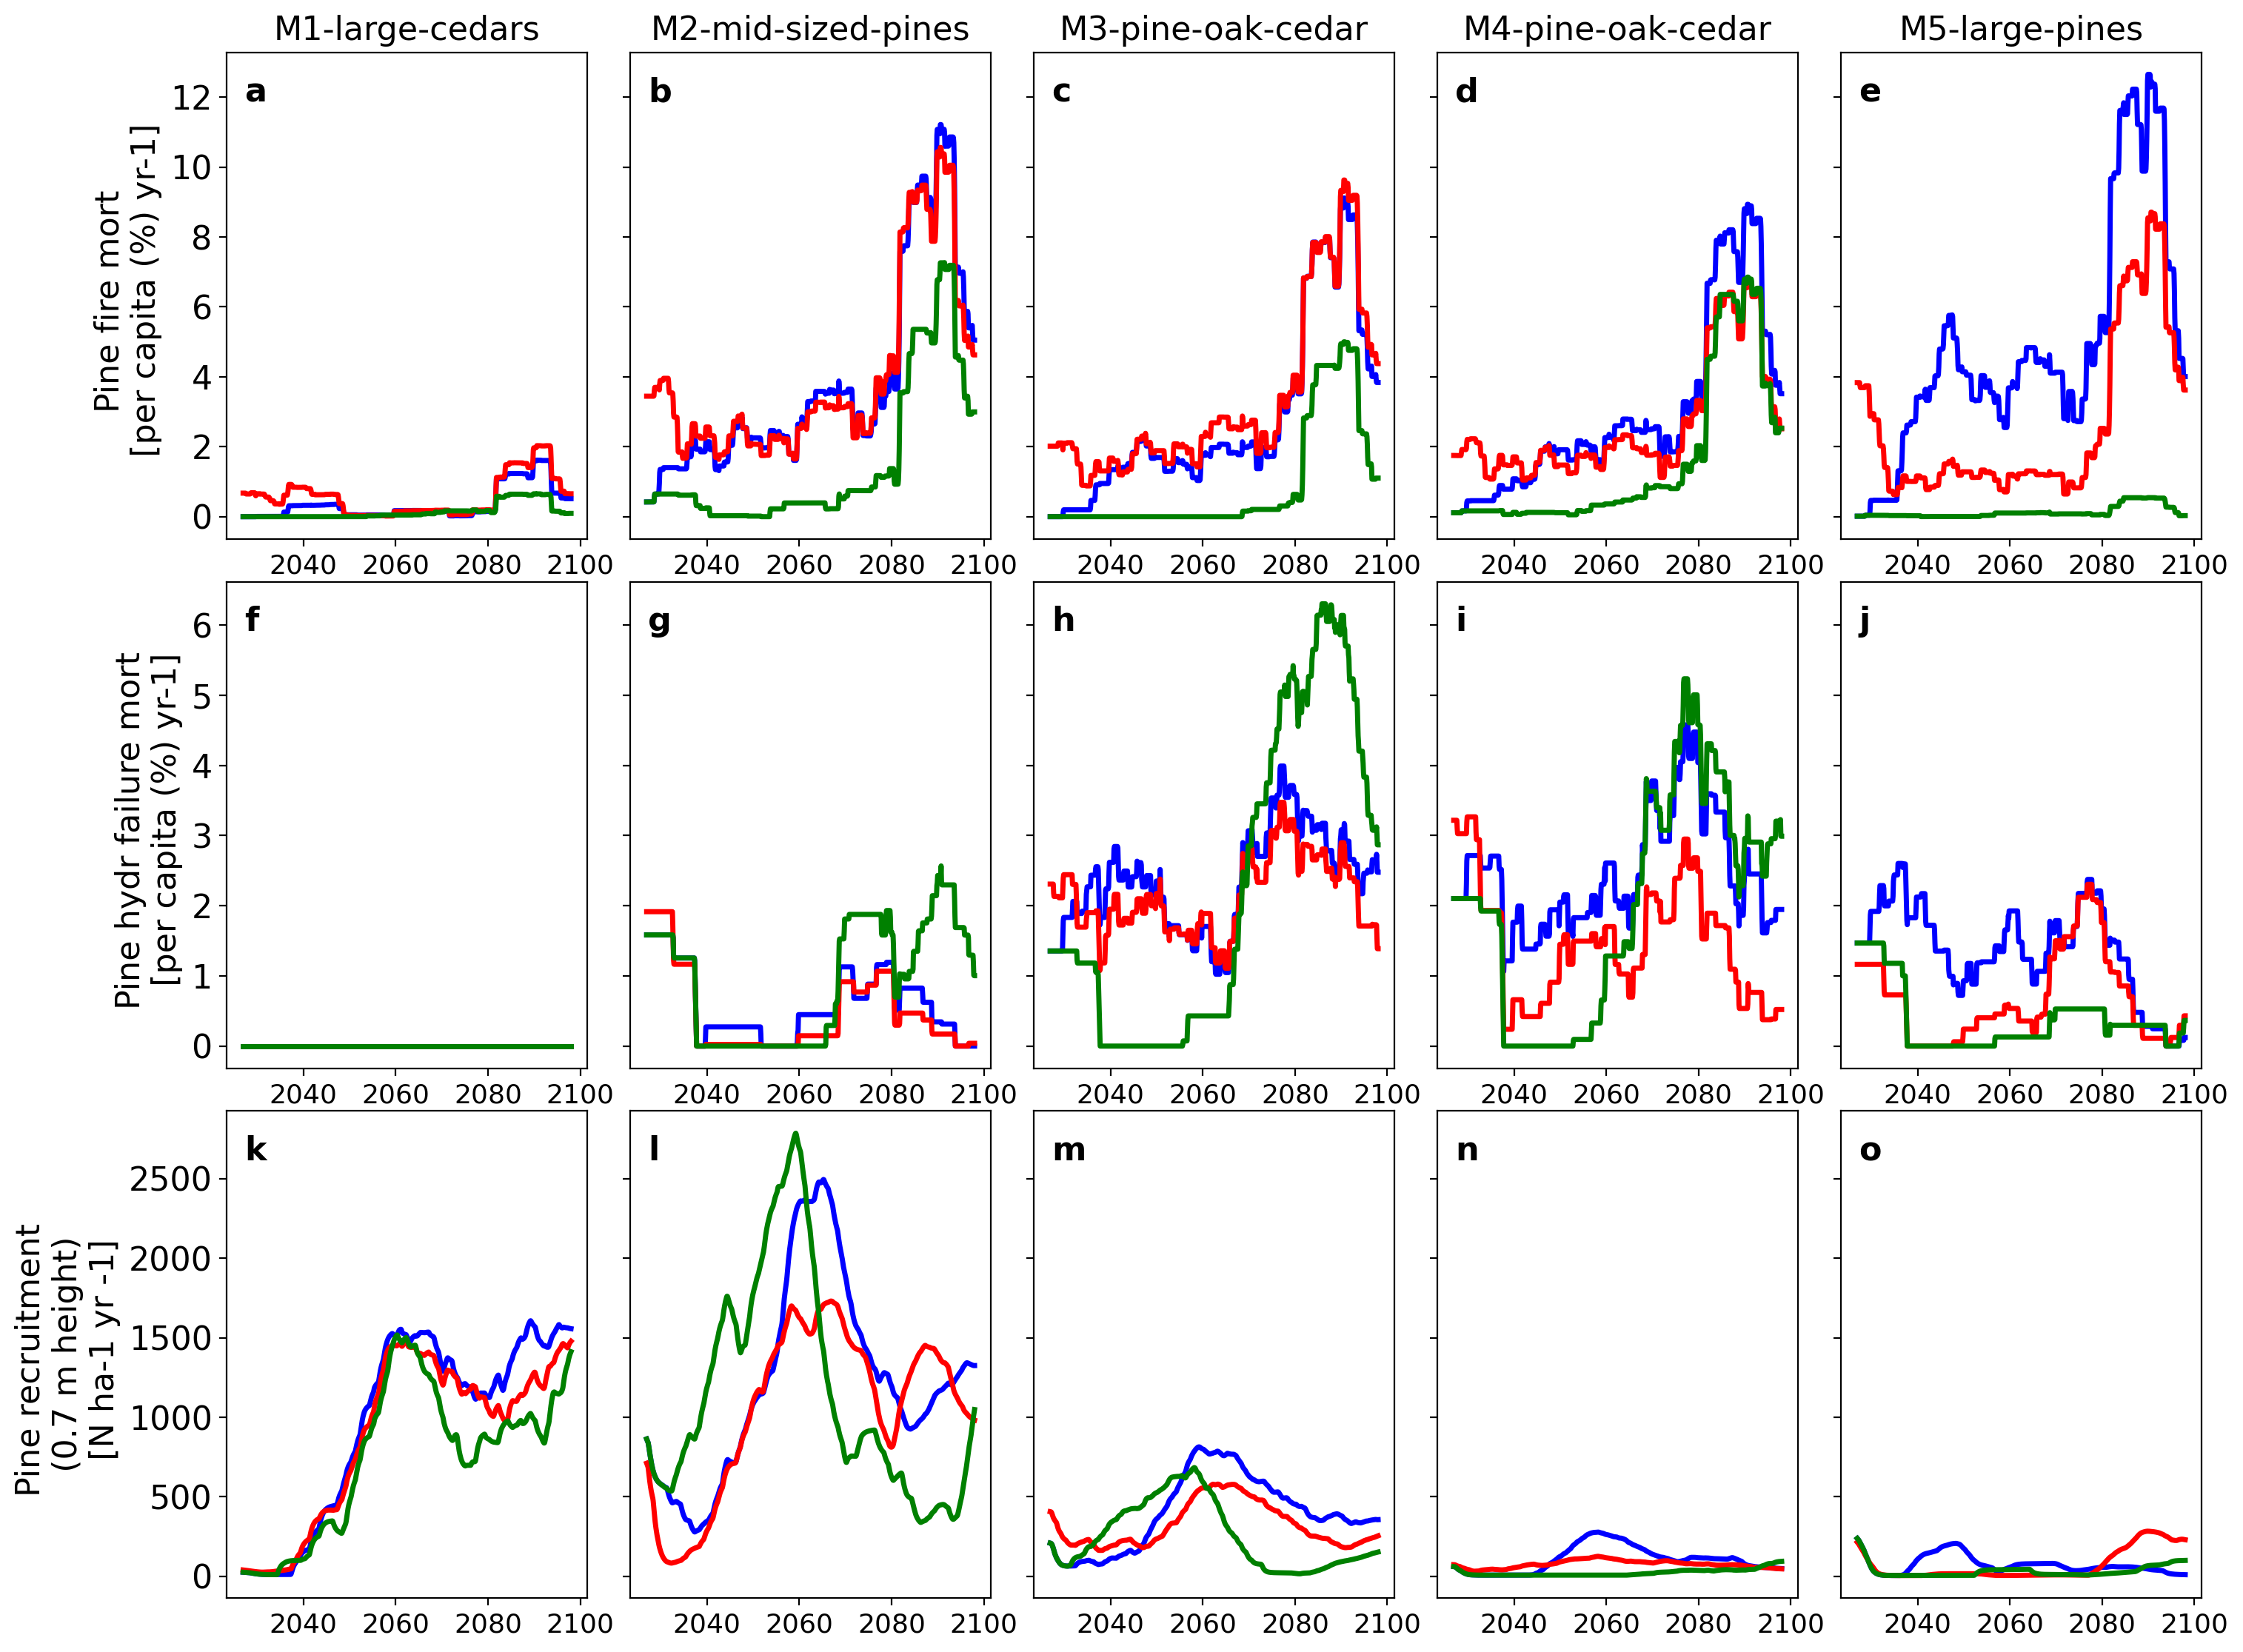

In [26]:
experimental_metrics = ['mort_pine_fire_per_cap','mort_pine_hydr_per_cap','Rec_pine']
compare_ts(full_ts,experimental_metrics,[1,2,3,4,5],"2010-01-01","2098-01-01",add_obs = False, figName = "main",saveFig=True, ymin=None, ymax = None)

/glade/u/home/adamhb/california-fates/figures/main.pdf


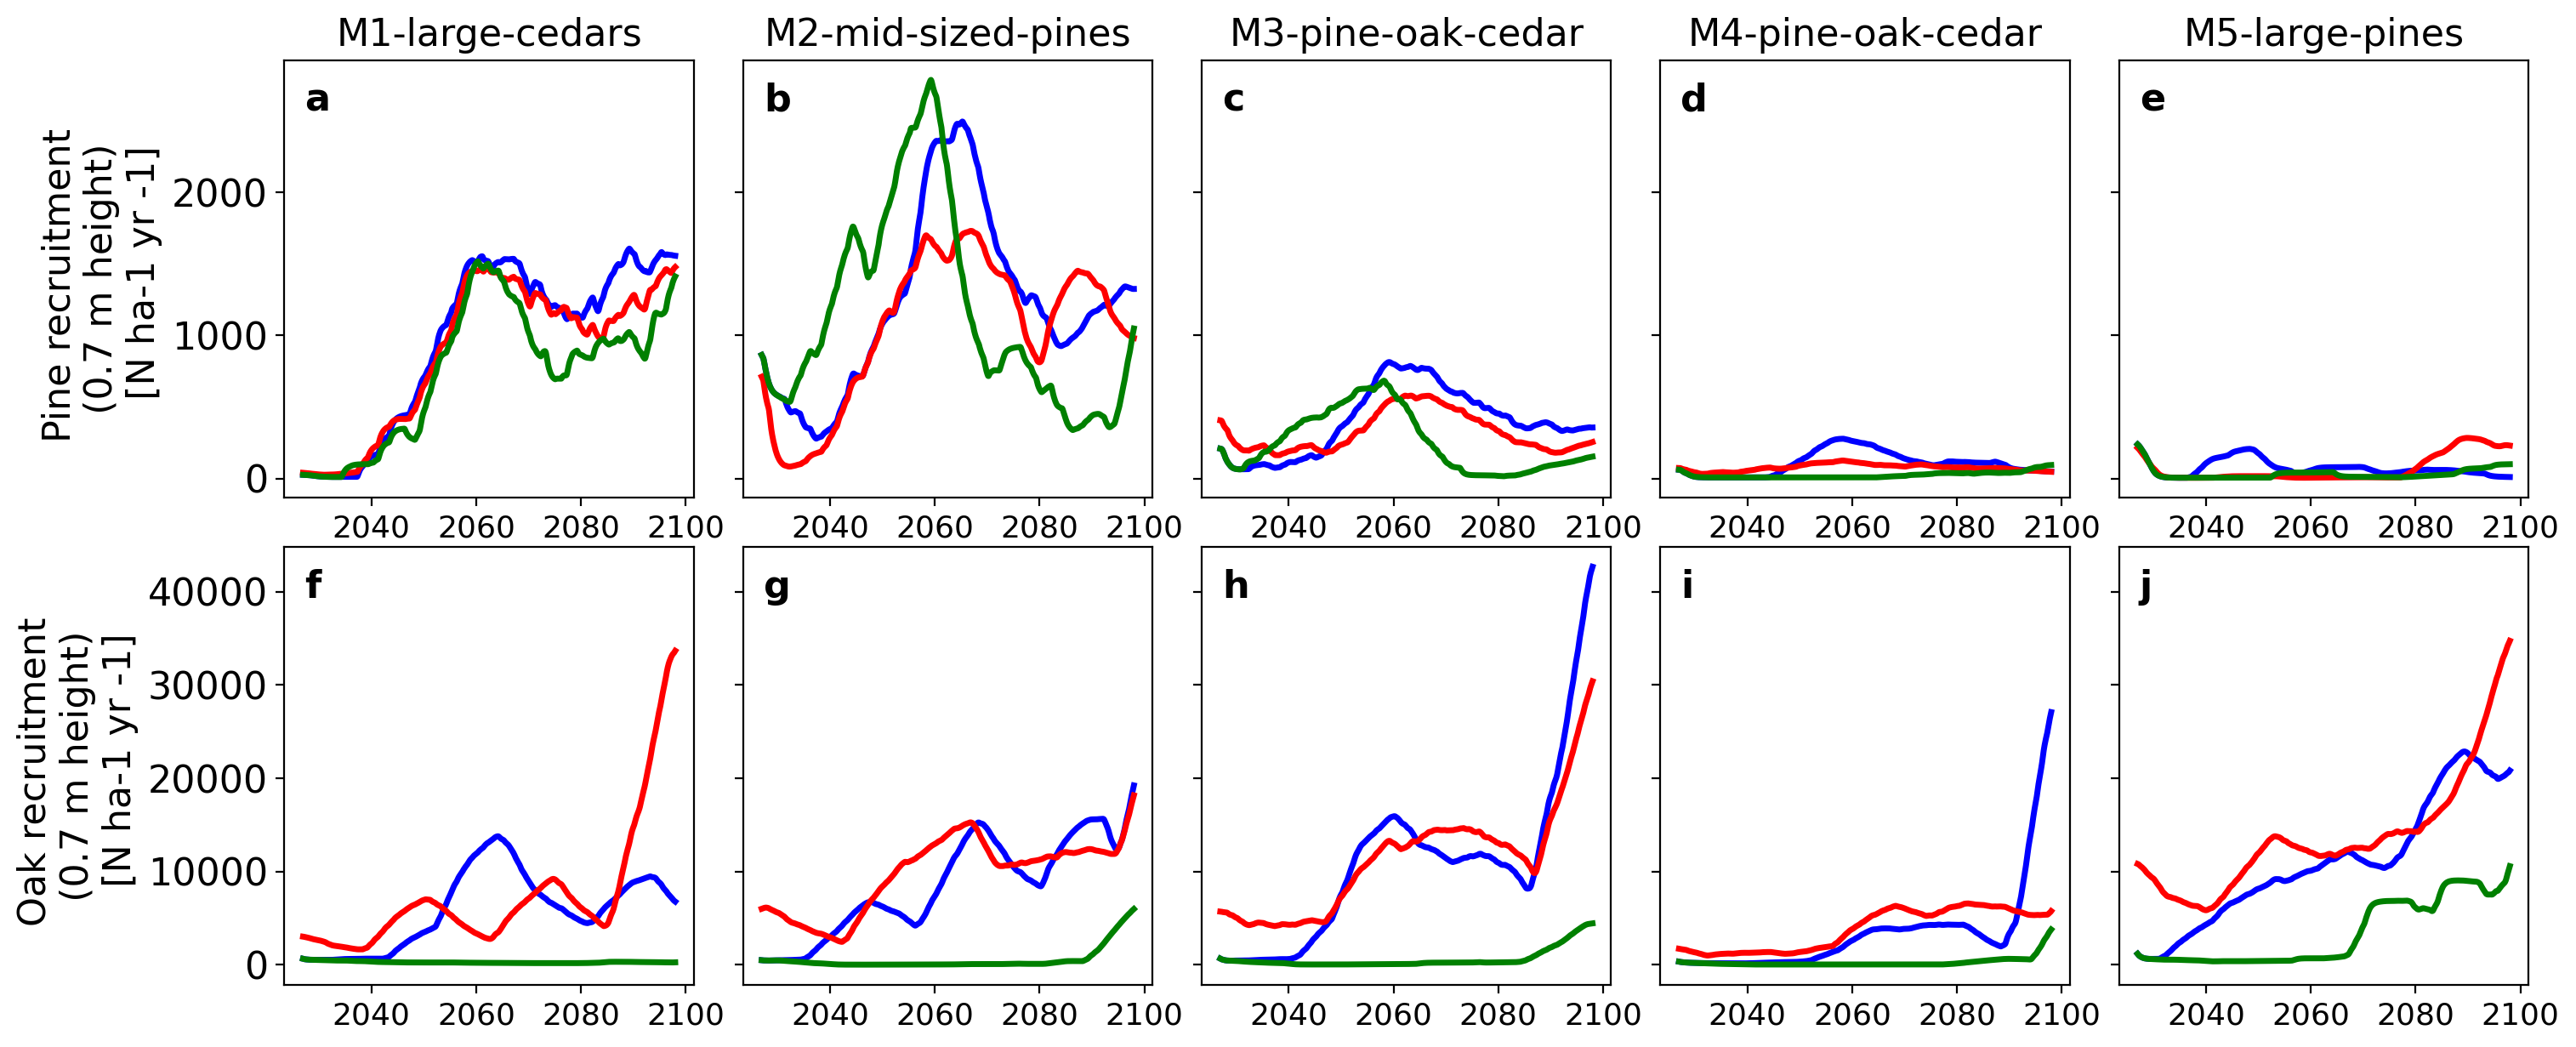

In [29]:
experimental_metrics = ['Rec_pine','Rec_oak']
compare_ts(full_ts,experimental_metrics,[1,2,3,4,5],"2010-01-01","2098-01-01",add_obs = False, figName = "main",saveFig=True, ymin=None, ymax = None)

KeyError: 'Column not found: B'

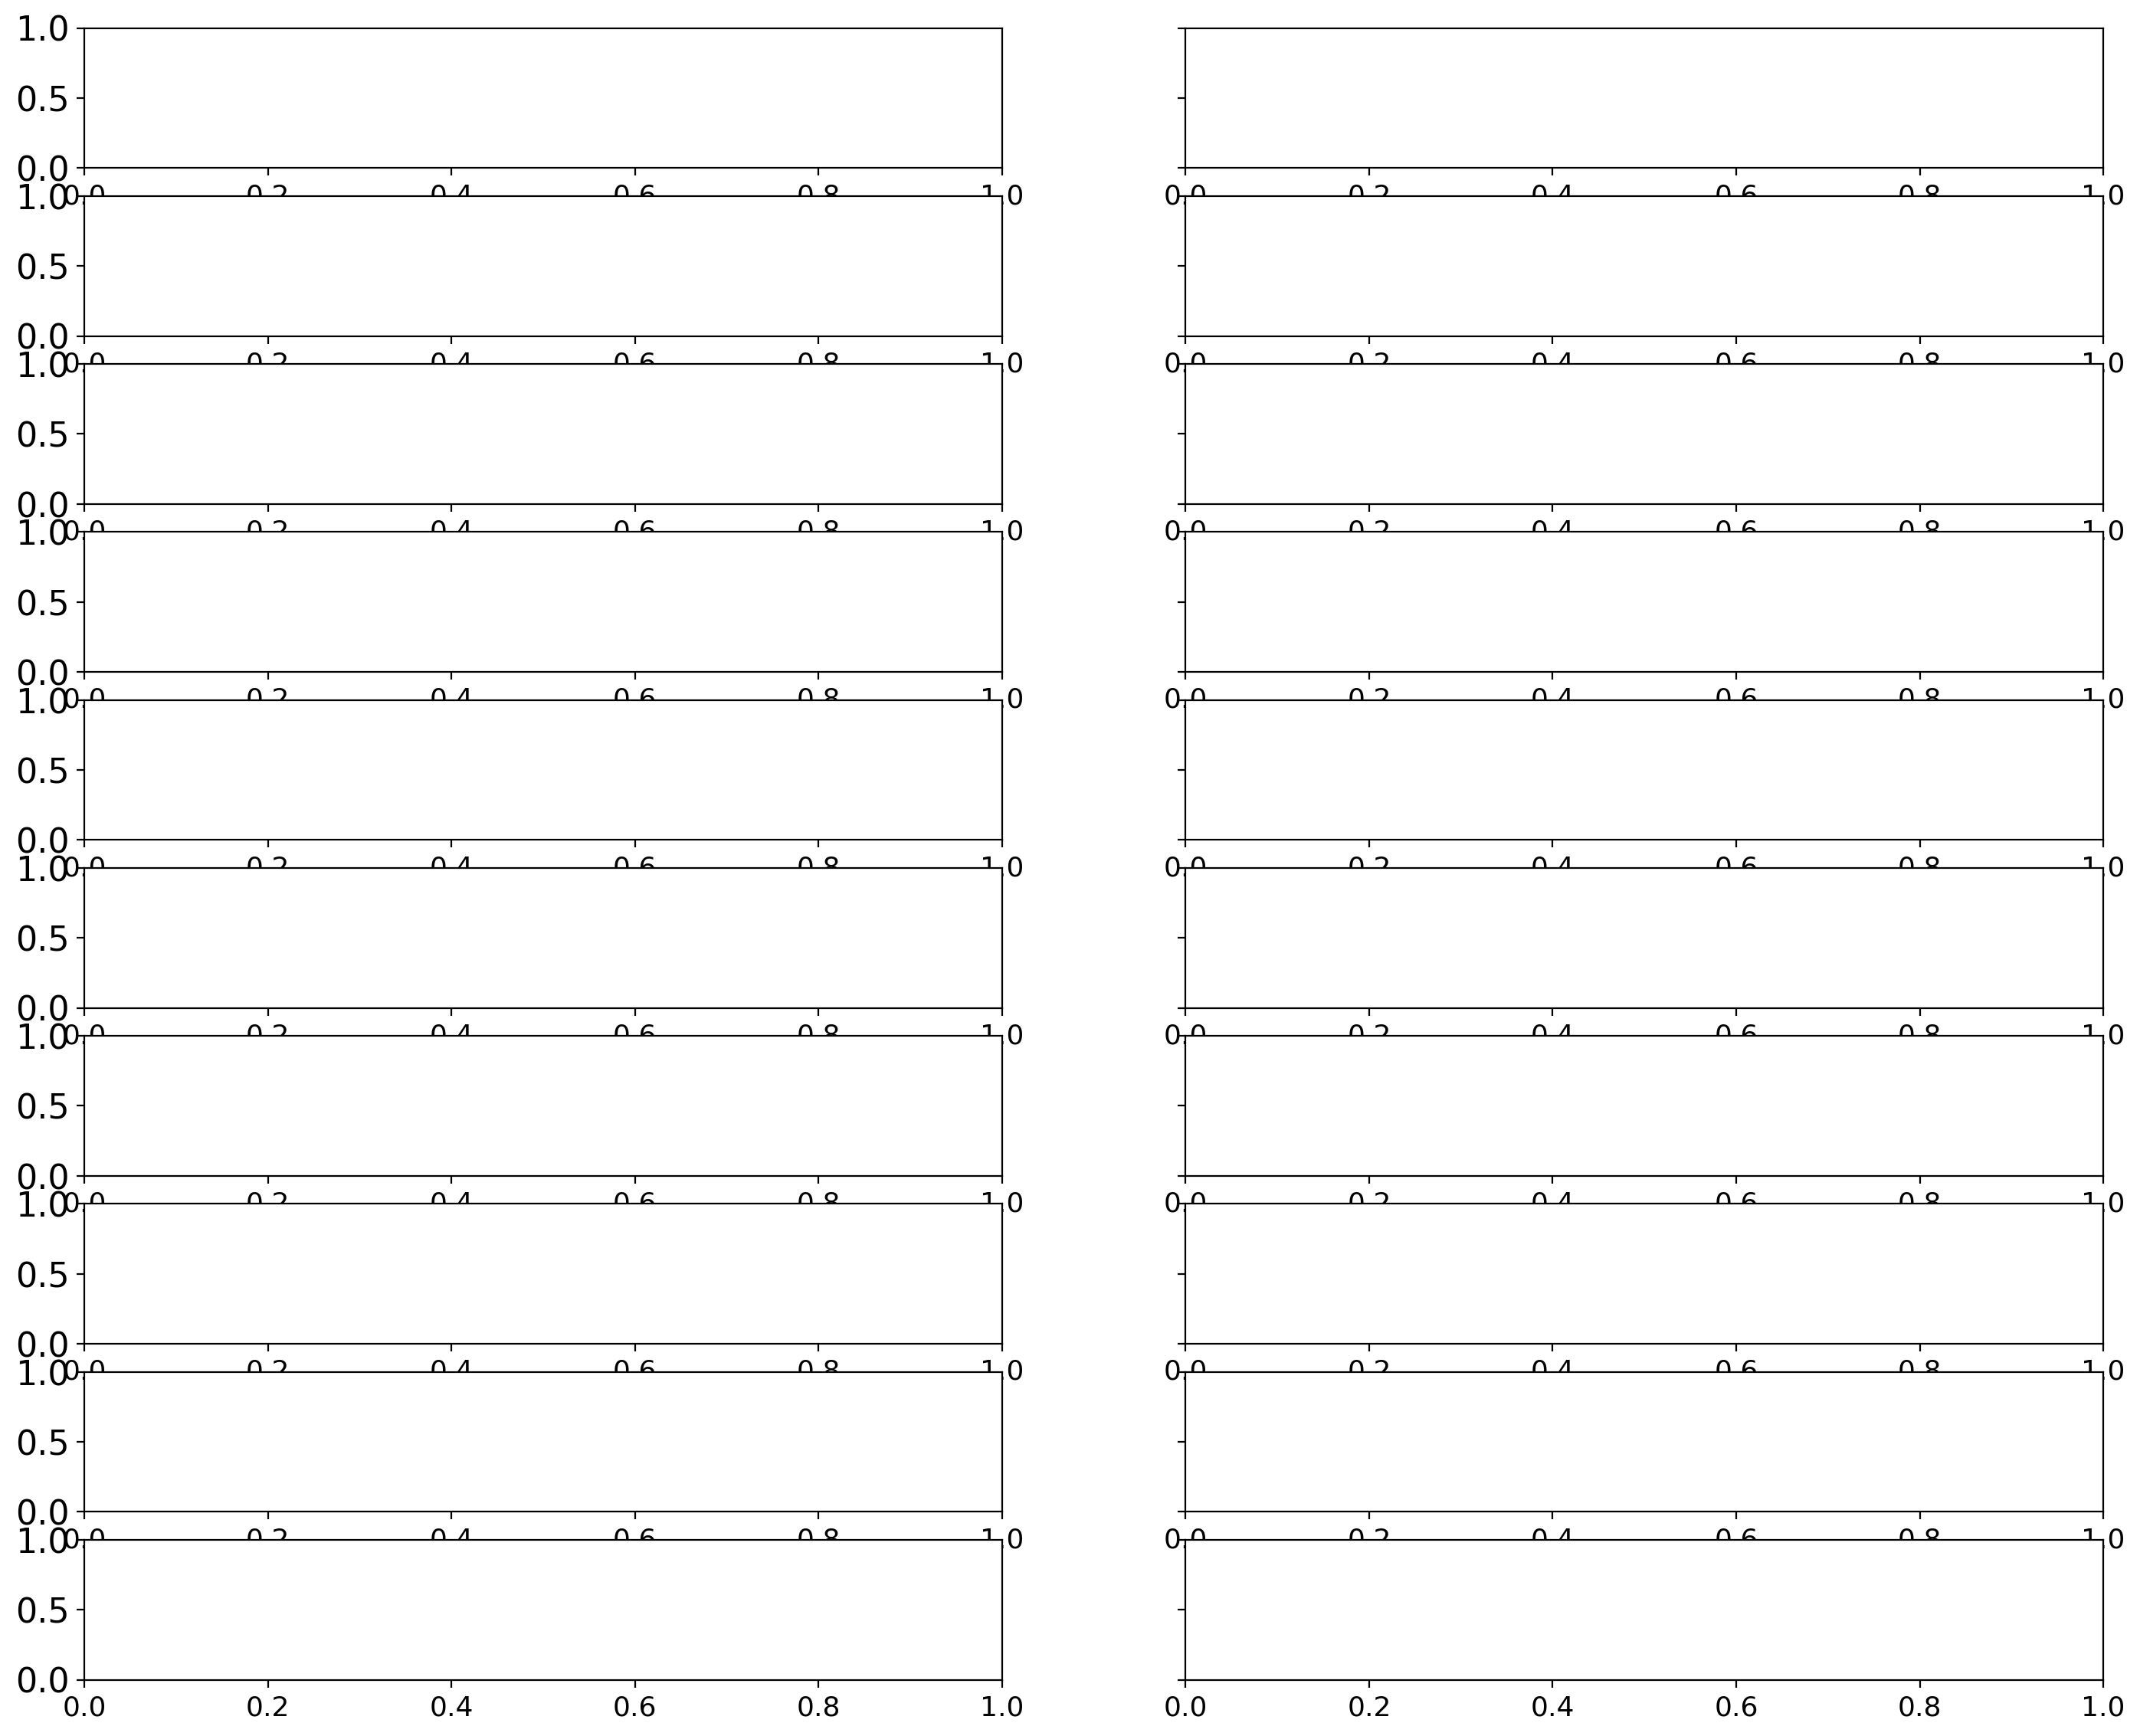

In [50]:
compare_ts(full_ts,"BA_conifer",[4,5],"2010-01-01","2098-01-01",add_obs = False, figName = "flyer",saveFig=False)

### Demographics

/glade/u/home/adamhb/california-fates/figures/pine_demographics.pdf


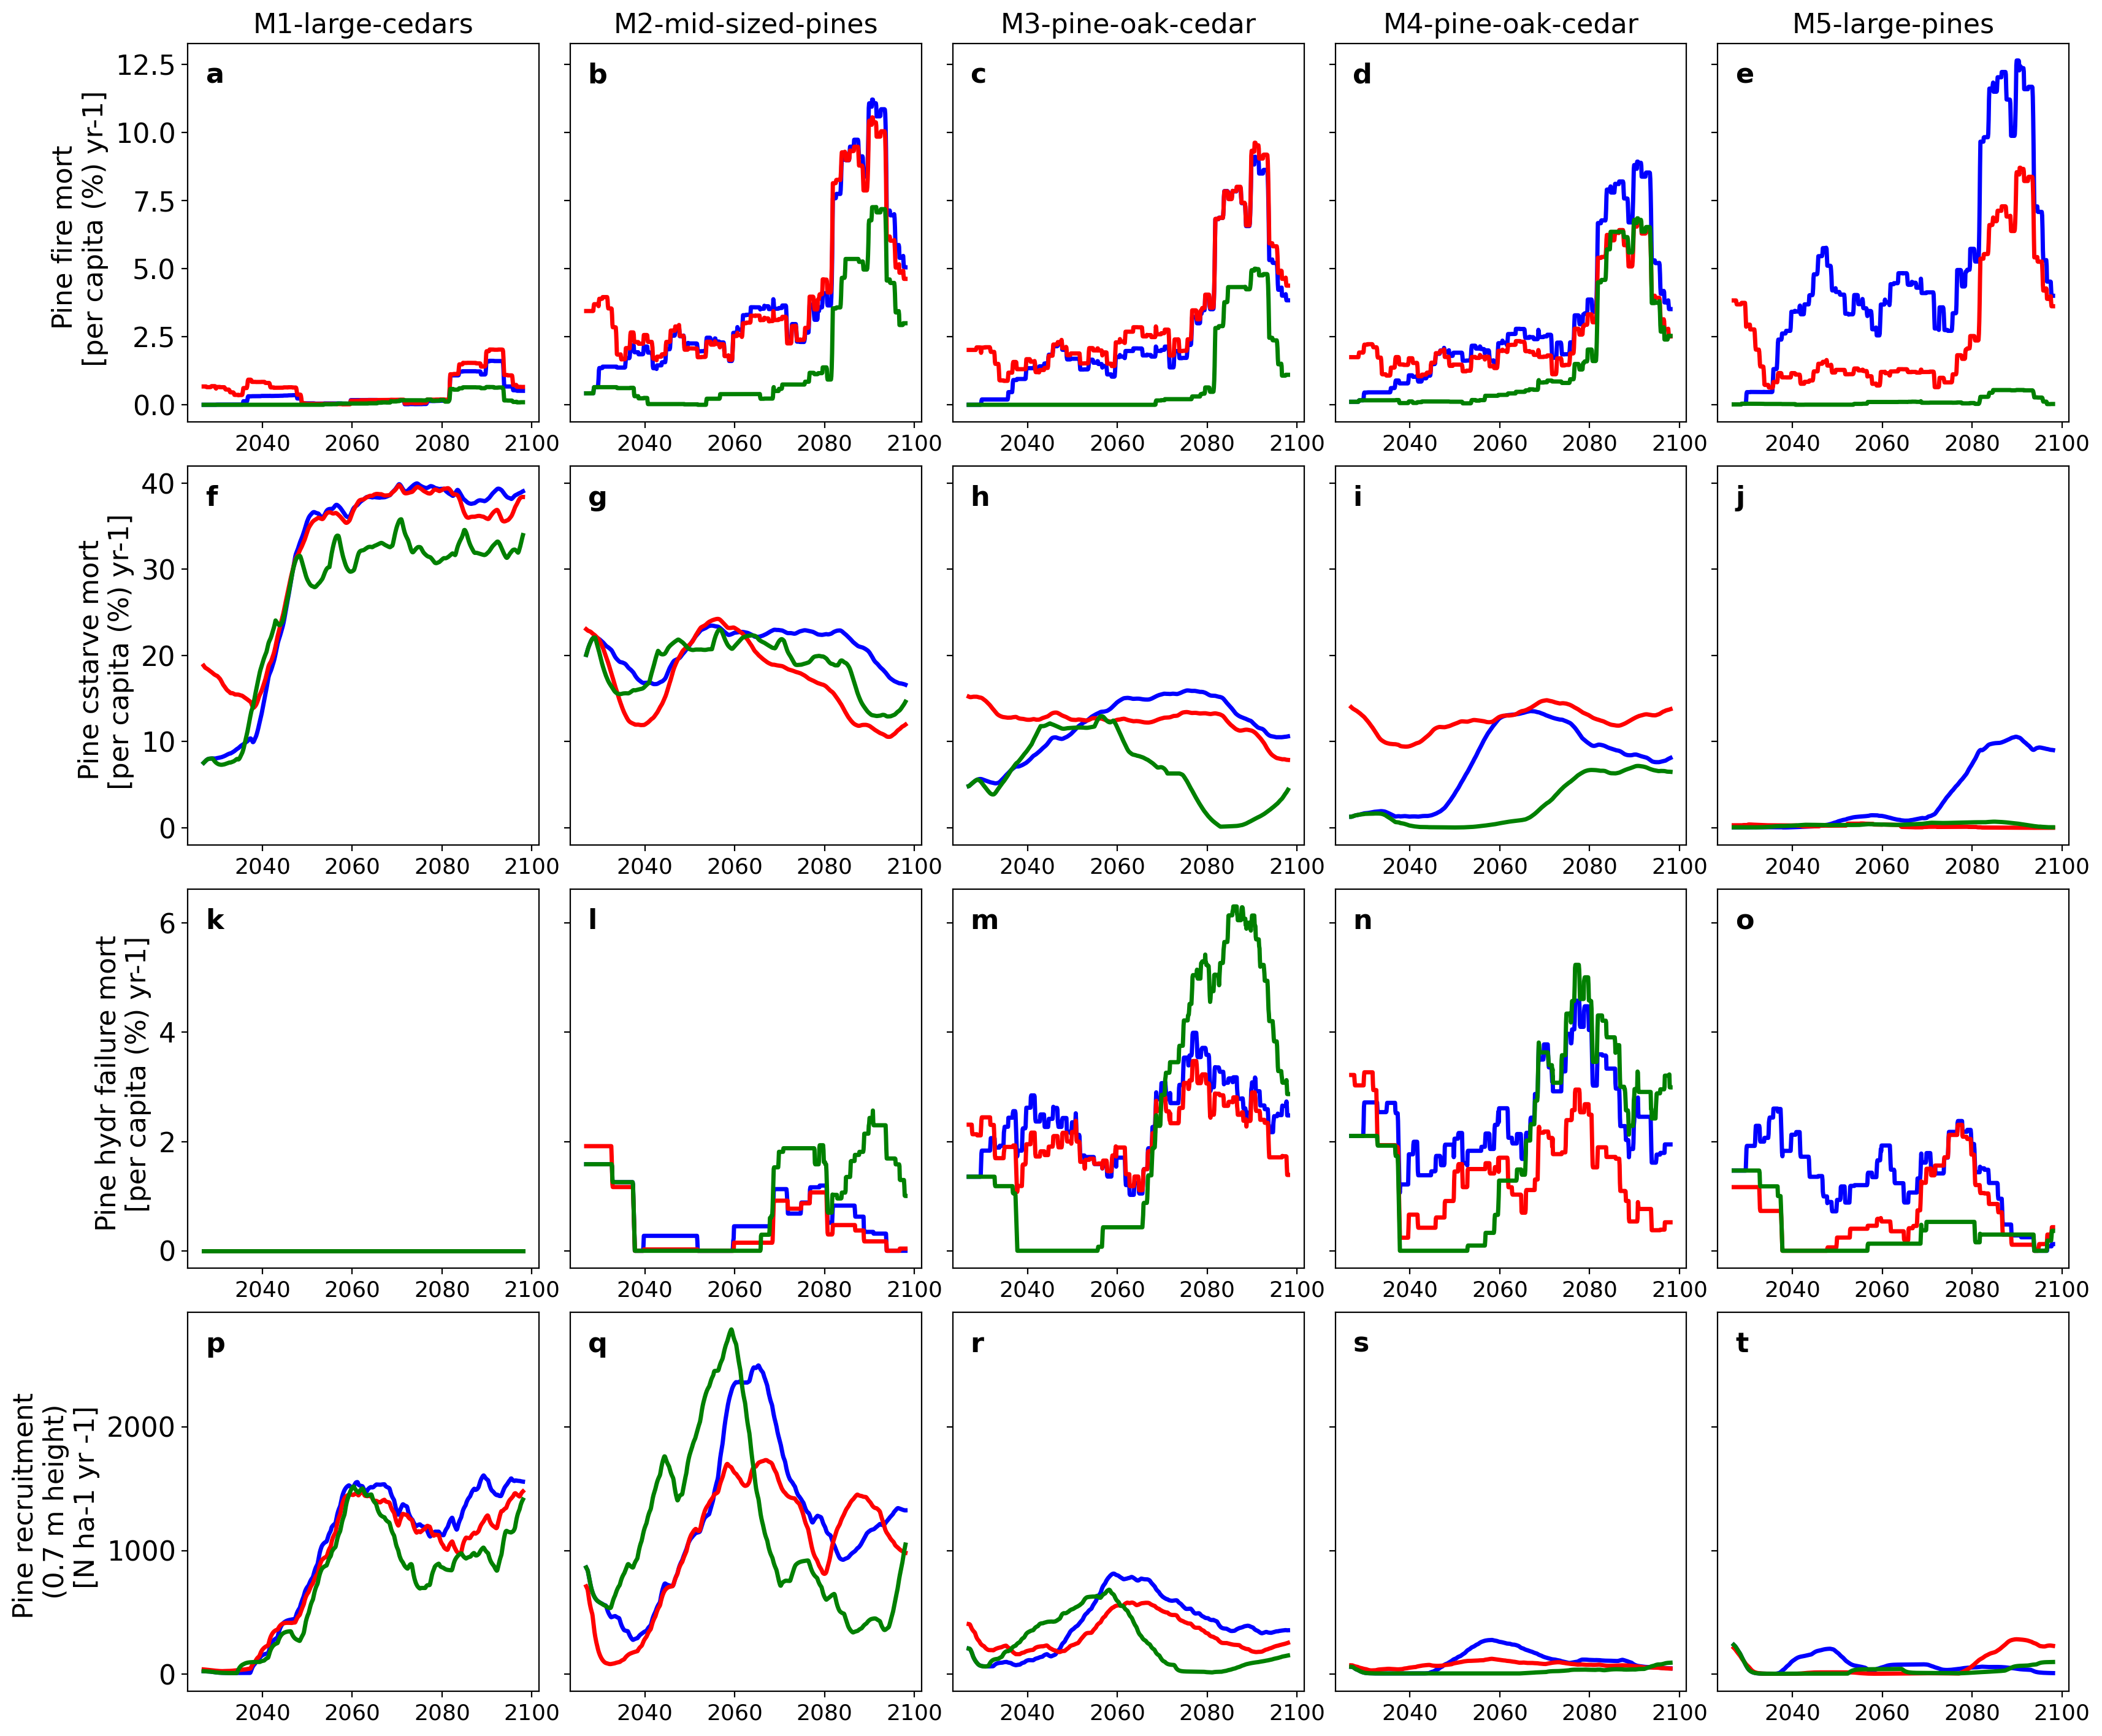

/glade/u/home/adamhb/california-fates/figures/cedar_demographics.pdf


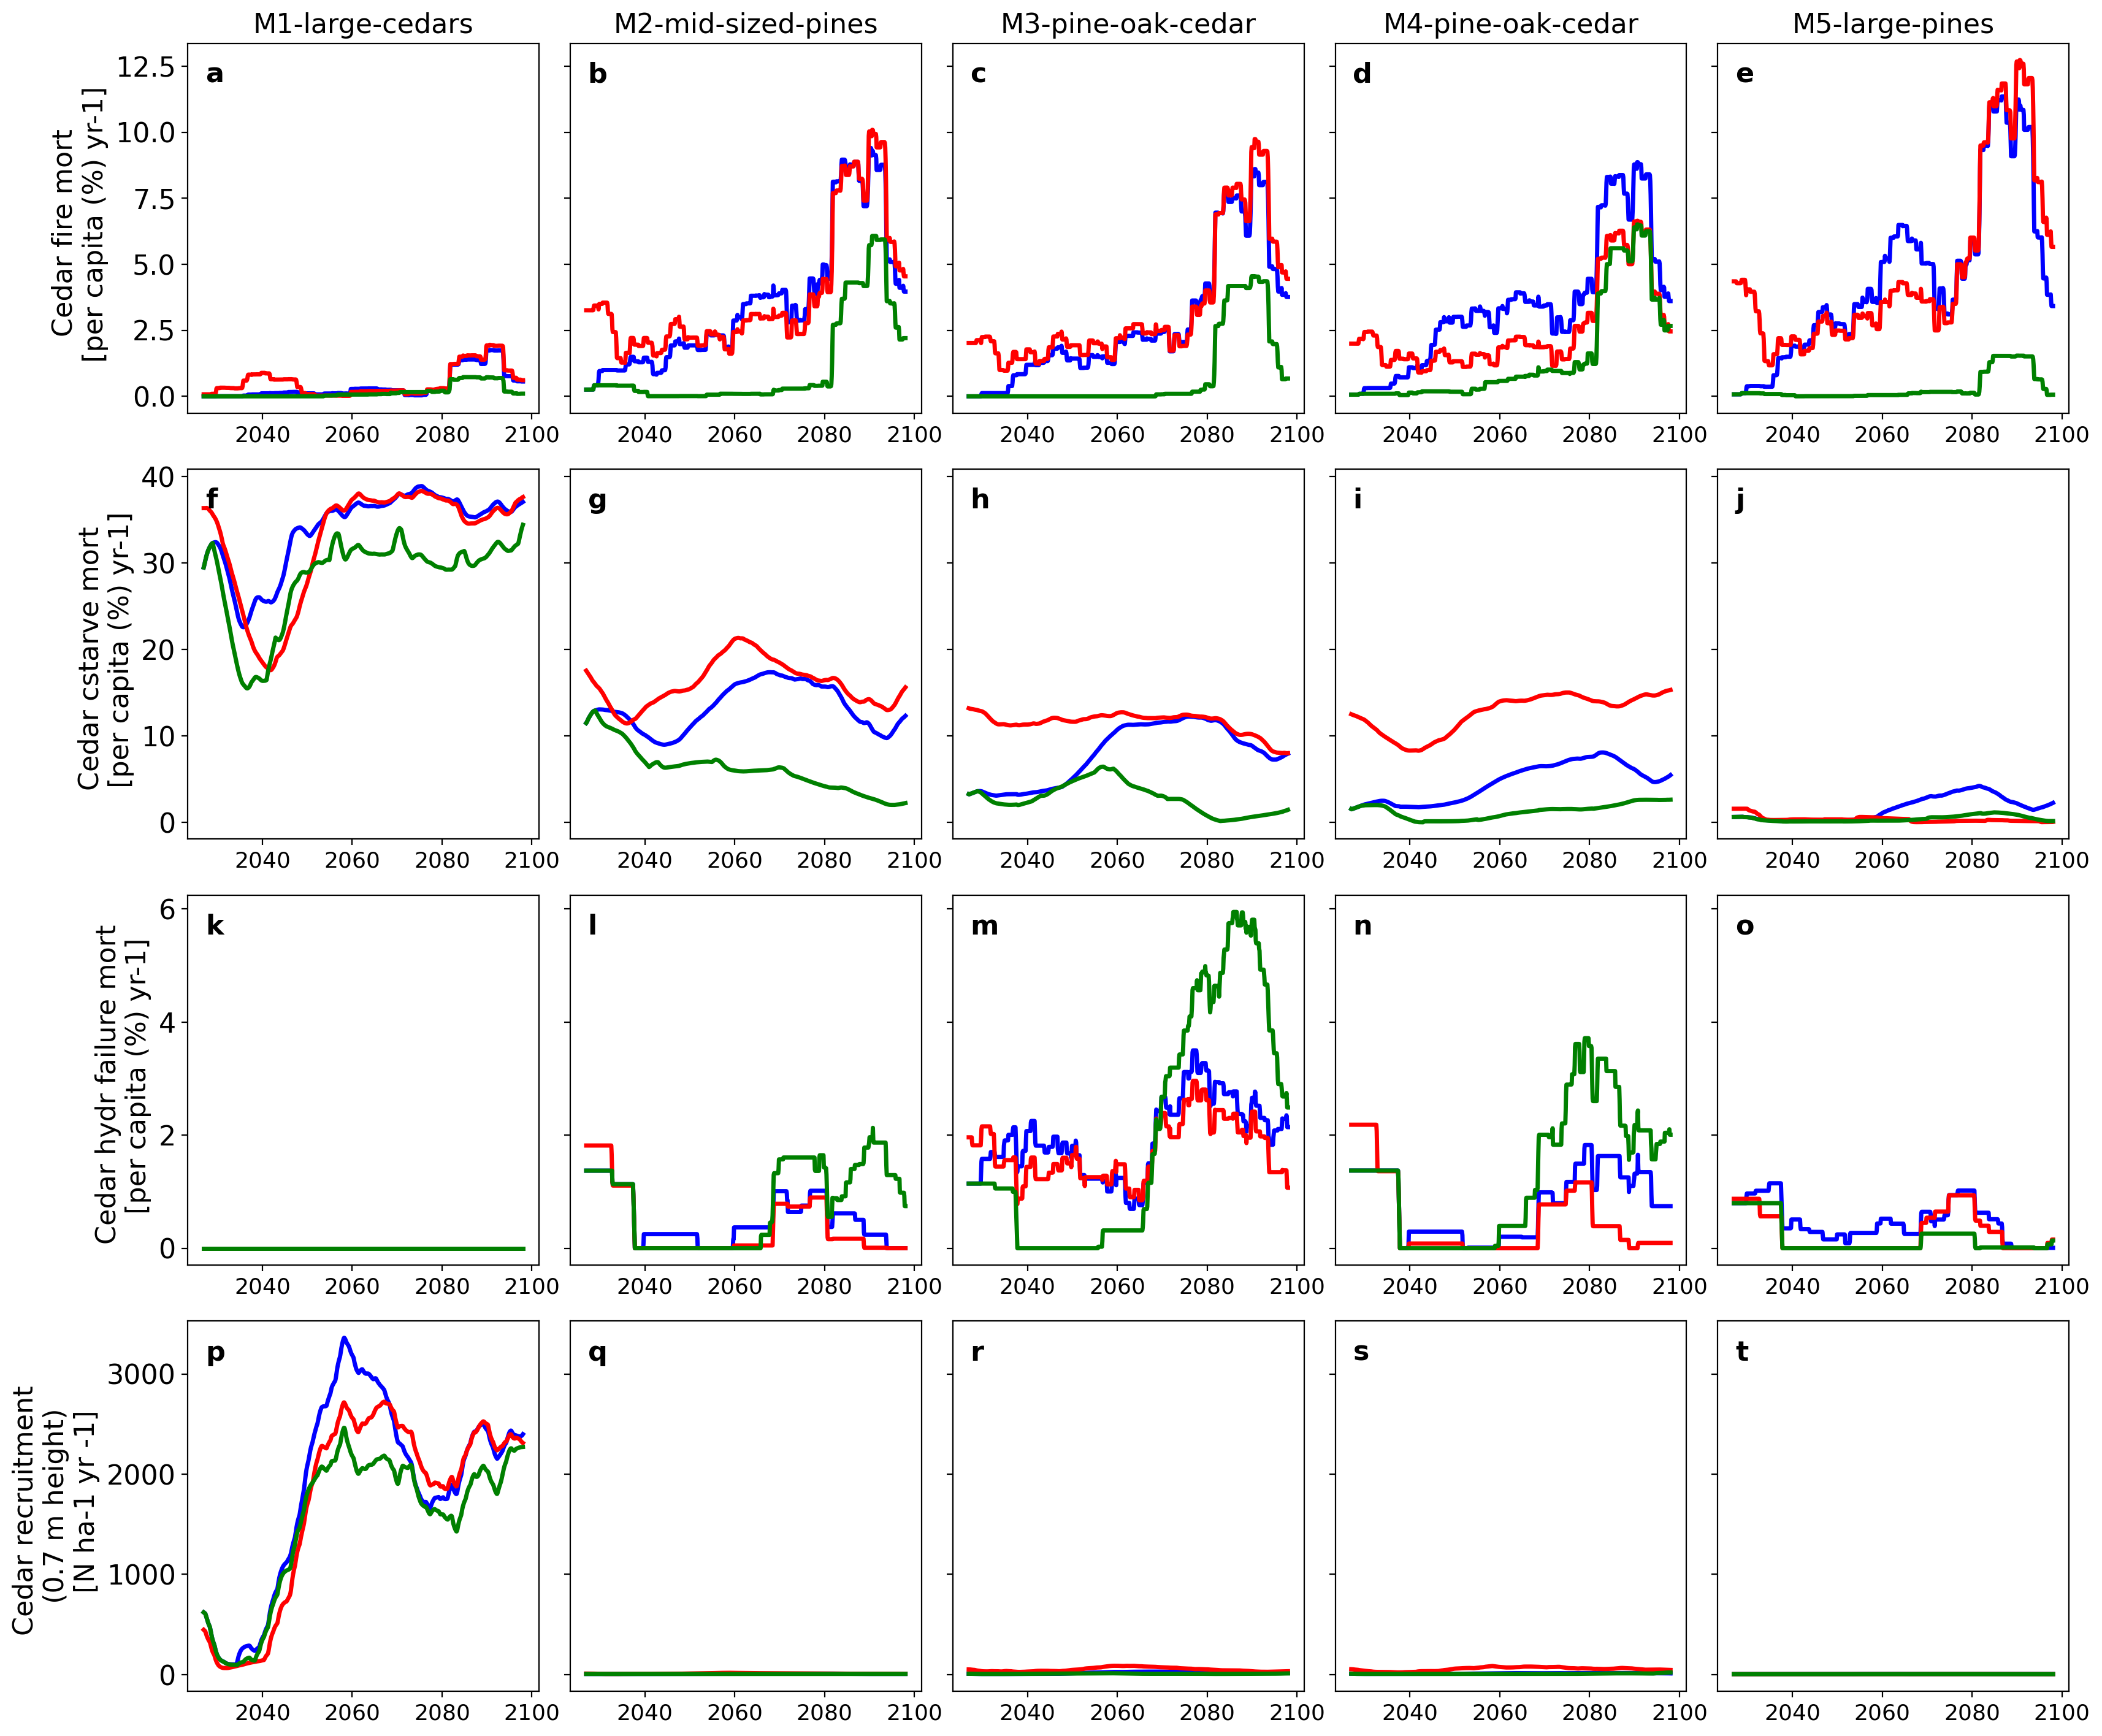

/glade/u/home/adamhb/california-fates/figures/fir_demographics.pdf


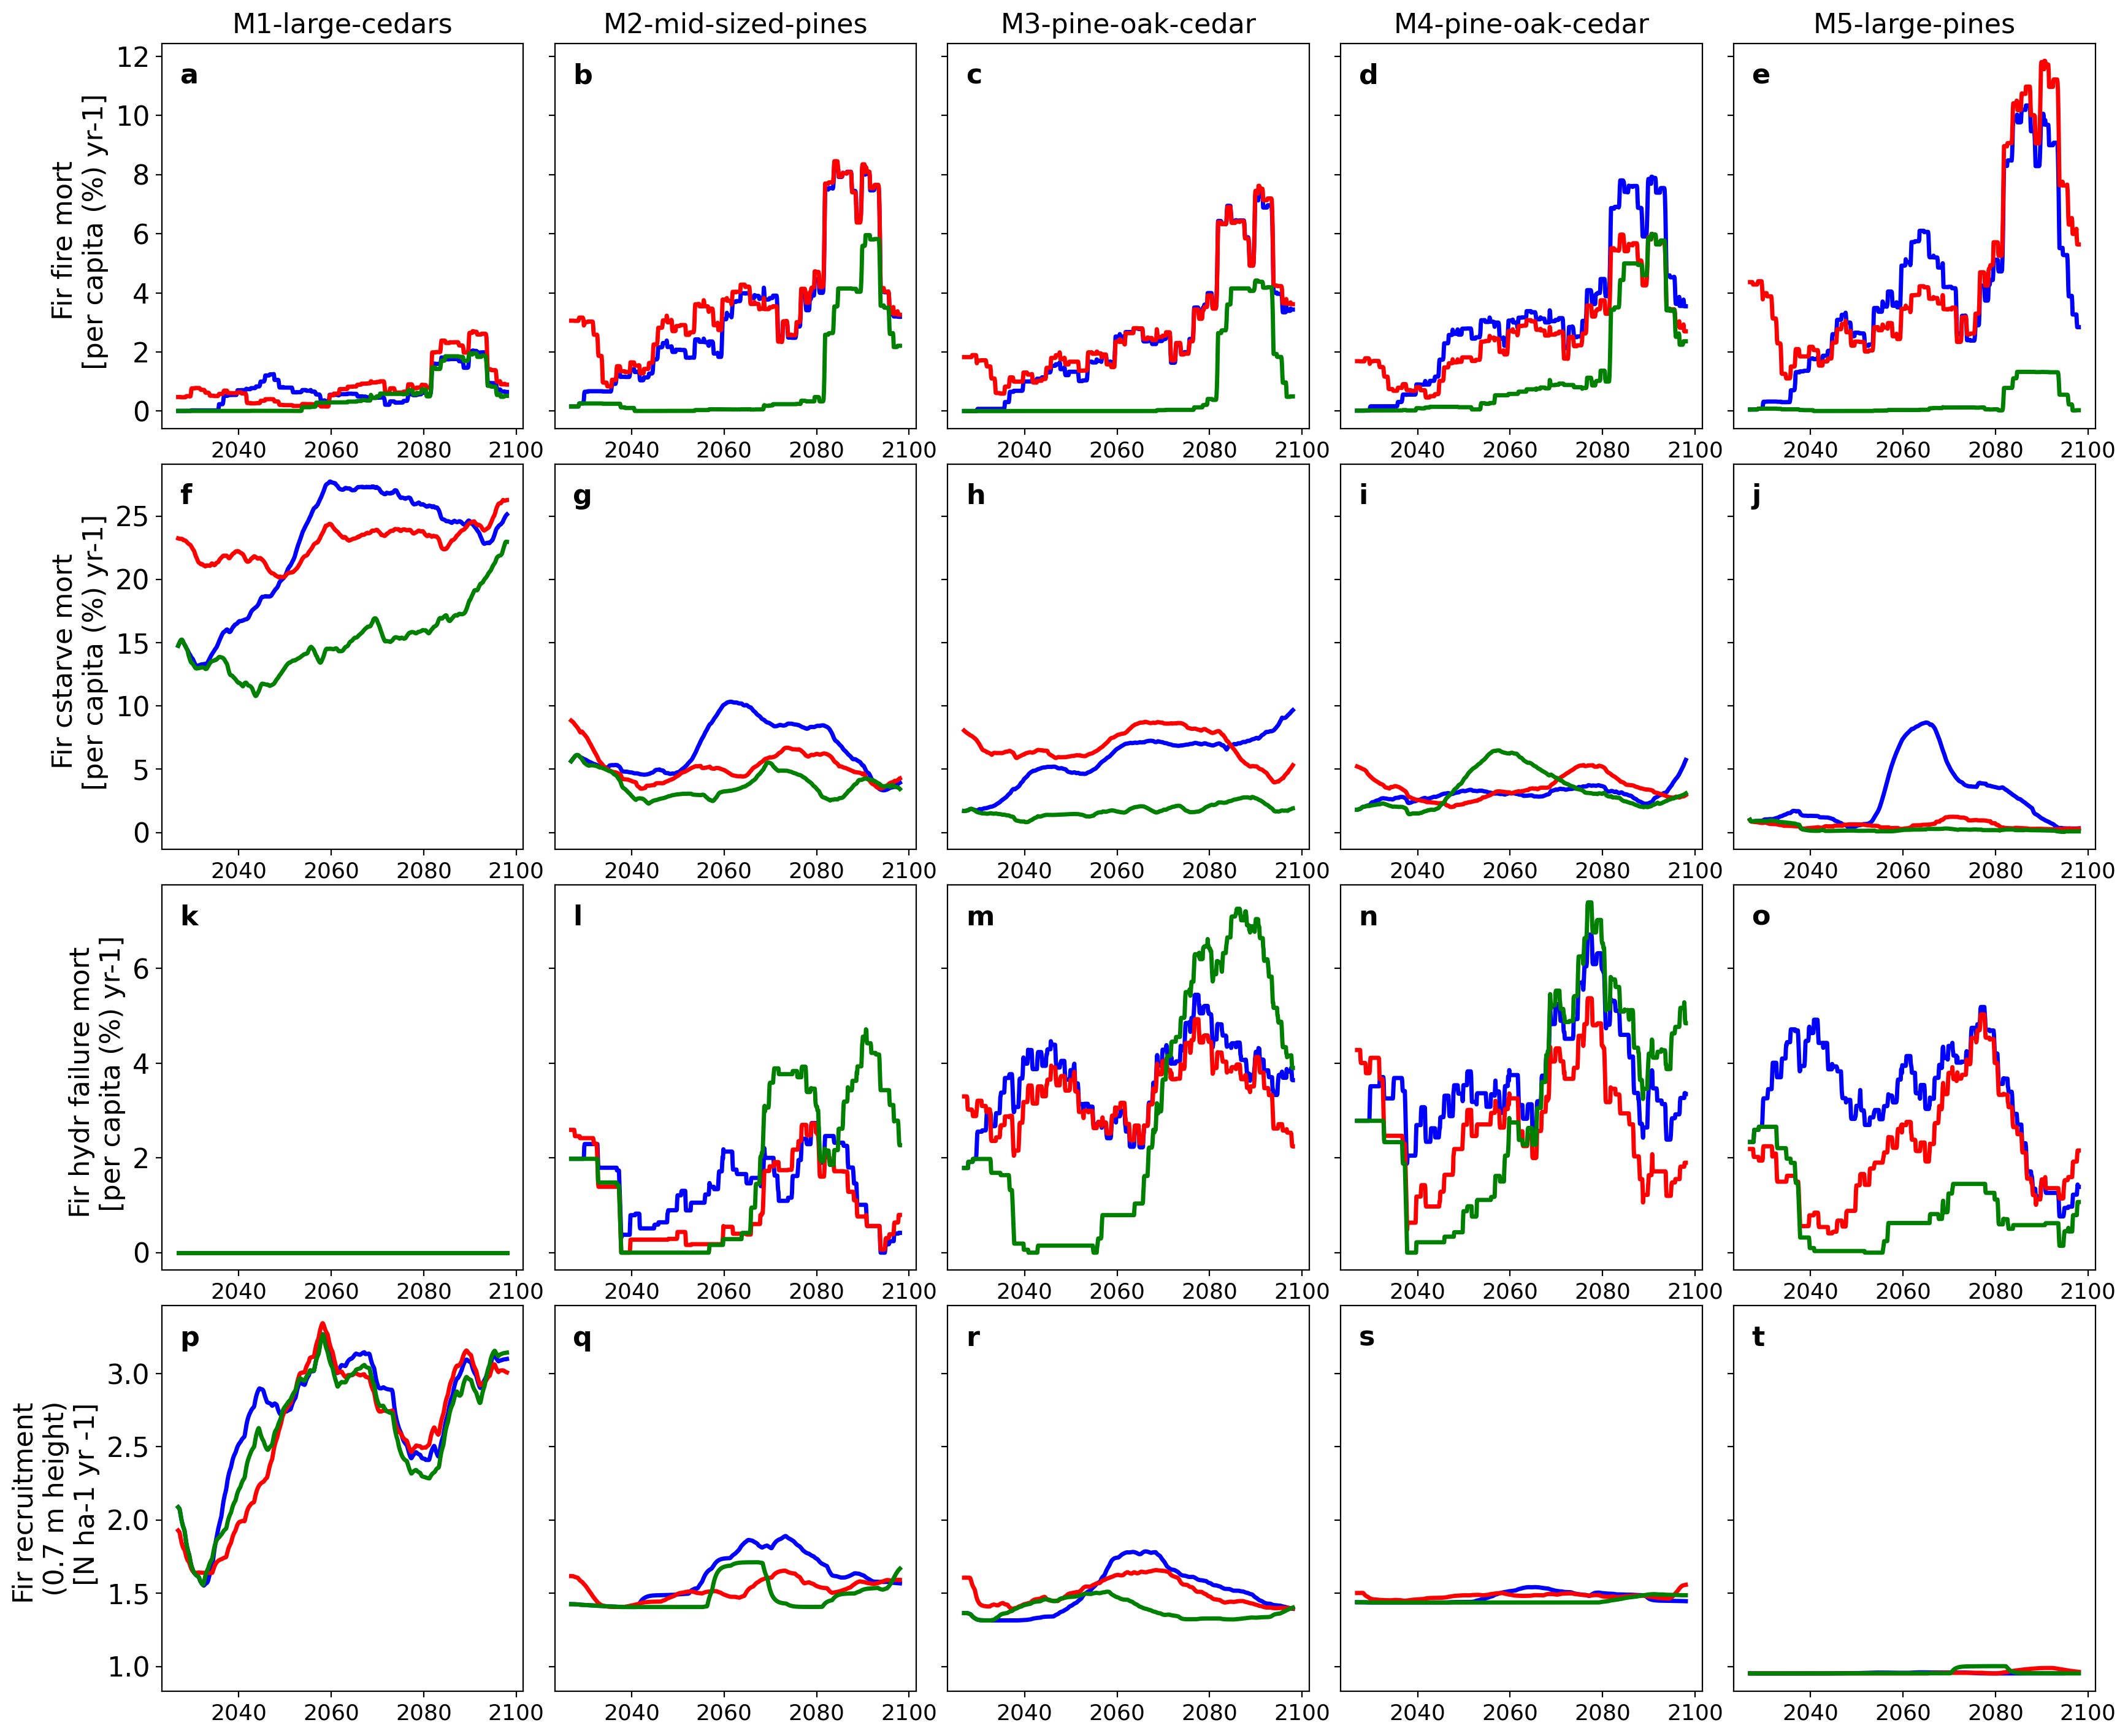

/glade/u/home/adamhb/california-fates/figures/shrub_demographics.pdf


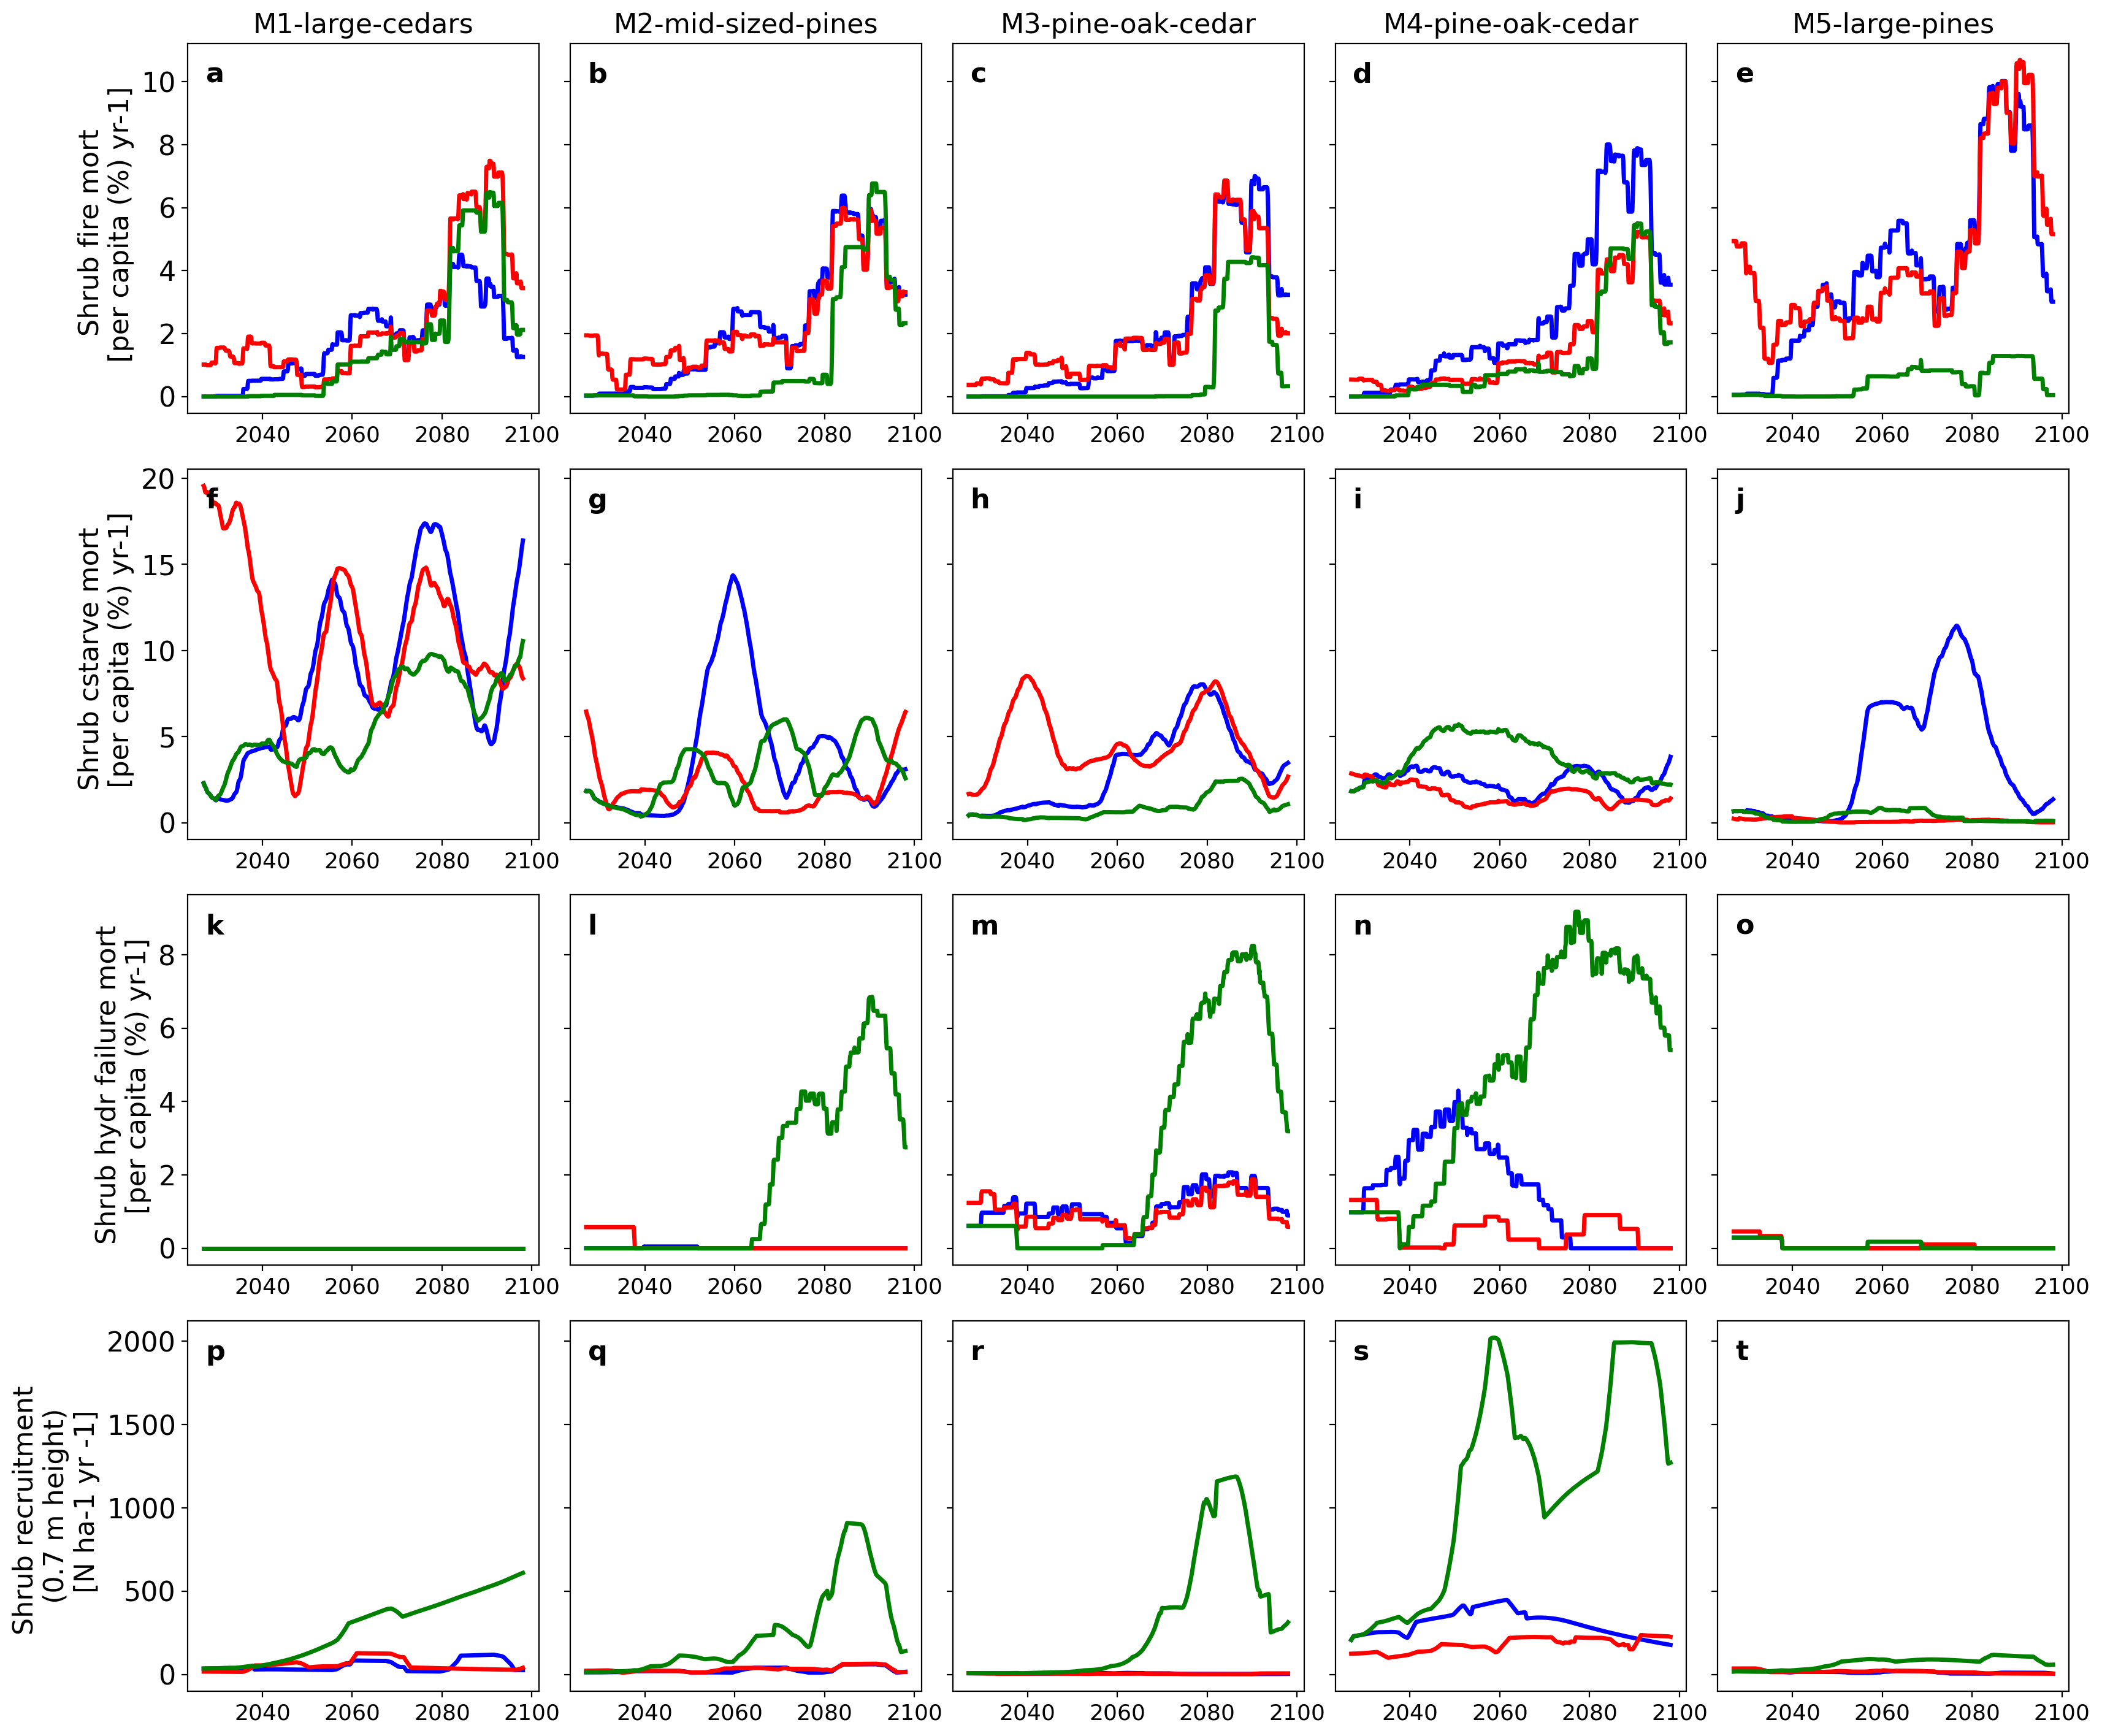

/glade/u/home/adamhb/california-fates/figures/oak_demographics.pdf


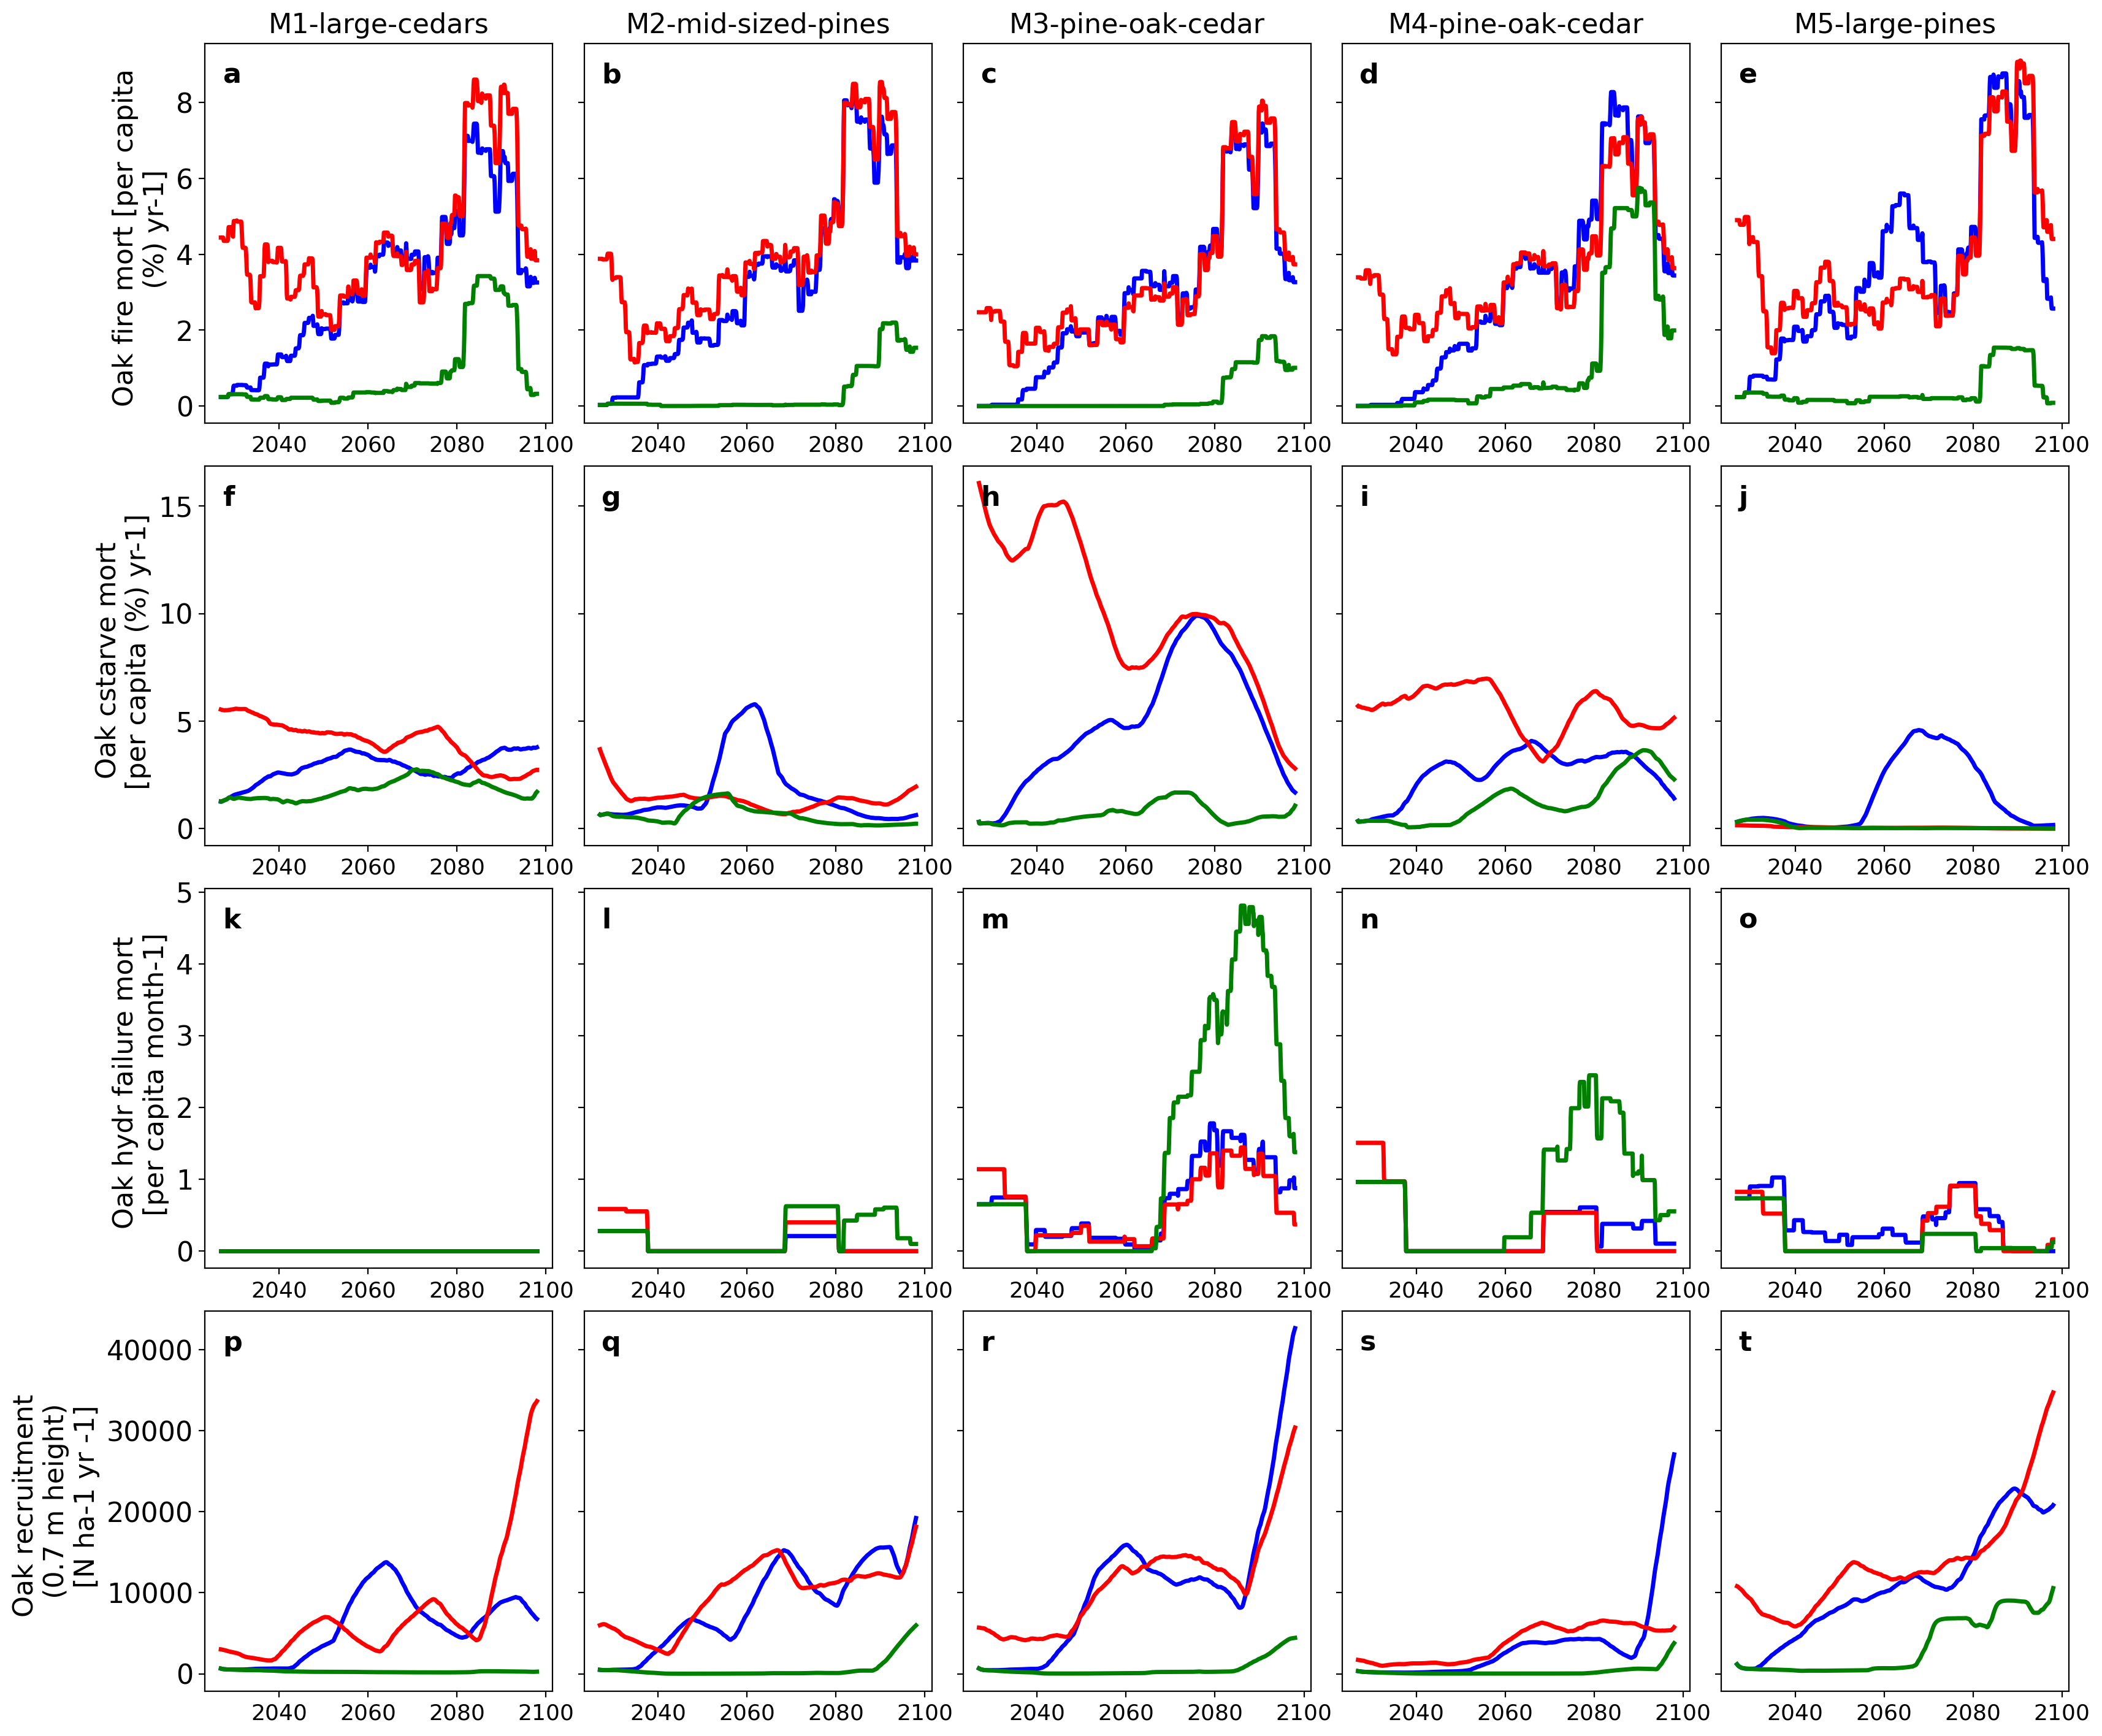

In [30]:
pft_names
for p in pft_names:
    demographics = [f'mort_{p}_fire_per_cap',f'mort_{p}_cstarve_per_cap',f'mort_{p}_hydr_per_cap',f'Rec_{p}']
    compare_ts(full_ts,demographics,[1,2,3,4,5],"2010-01-01","2098-01-01",add_obs = False, saveFig=True, figName=f'{p}_demographics')

### Fire metrics

/glade/u/home/adamhb/california-fates/figures/fire.pdf


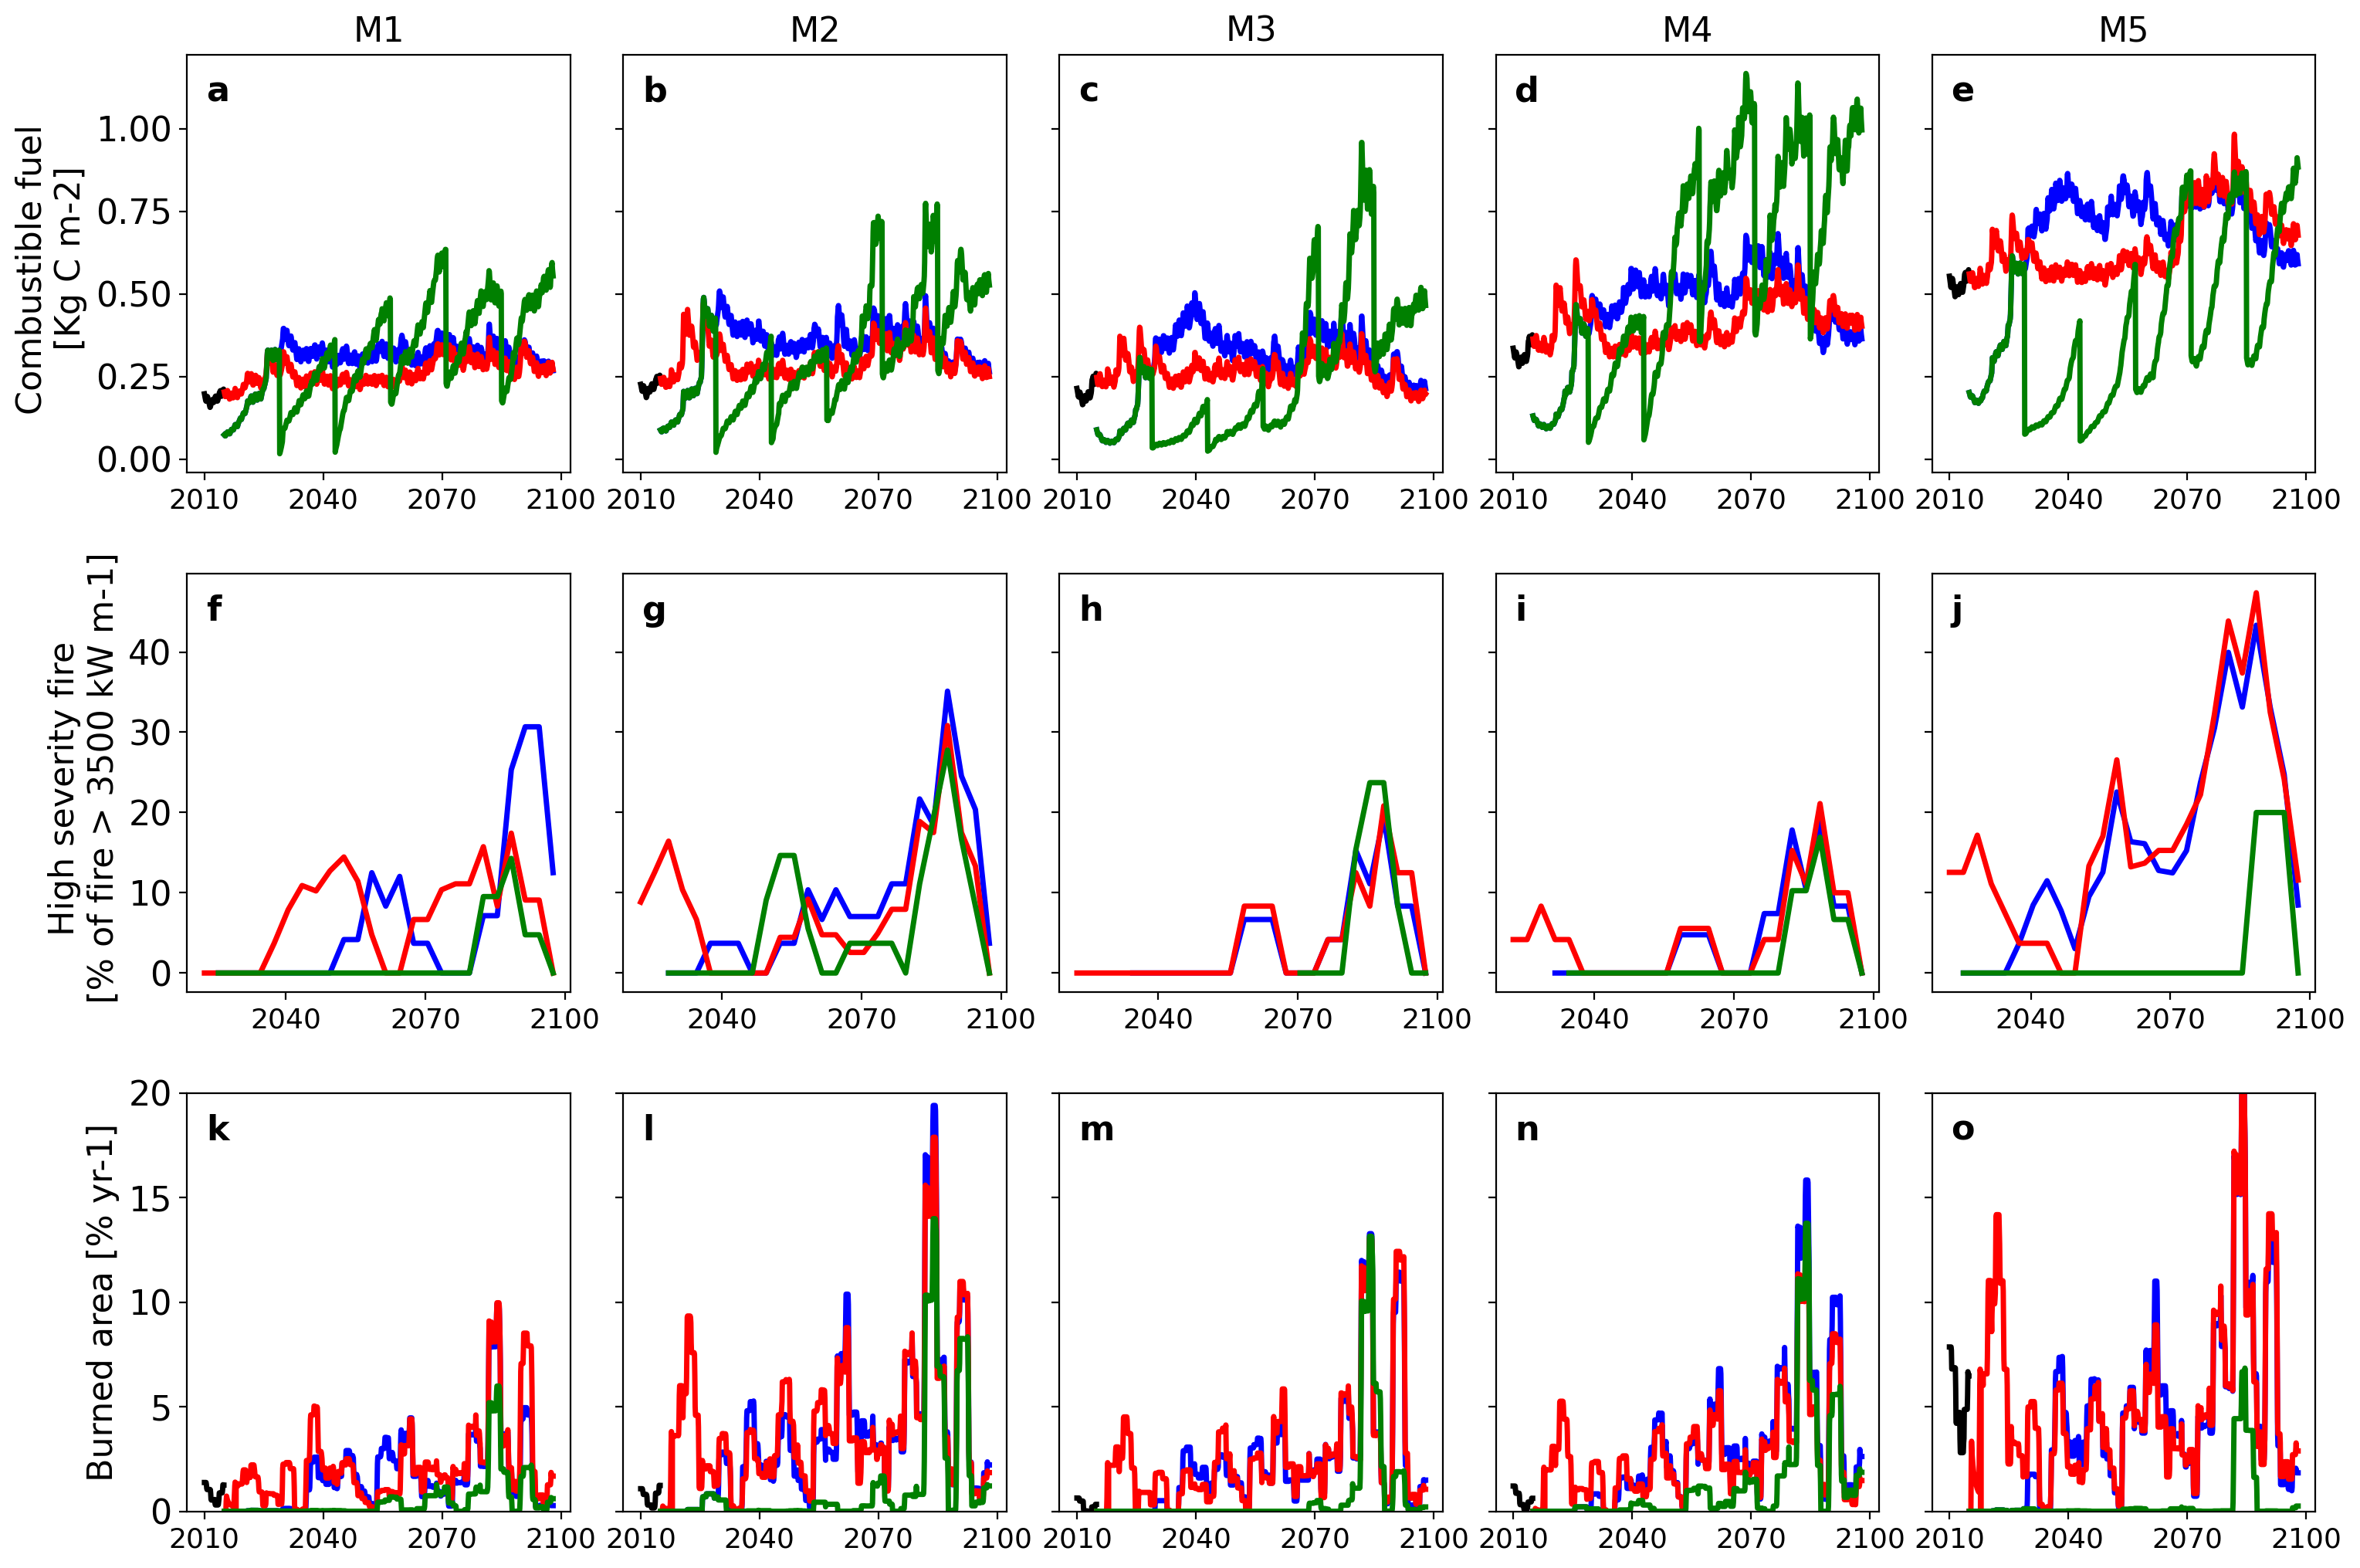

In [57]:
fire_metrics = ['Combustible_fuel','Pct_high_severity_3500','Burned_area']
compare_ts(full_ts,fire_metrics,[1,2,3,4,5],"2010-01-01","2098-01-01",add_obs = False, figName = "fire",saveFig=True)

### Misc vars

/glade/u/home/adamhb/california-fates/figures/smp-stem-npp.pdf


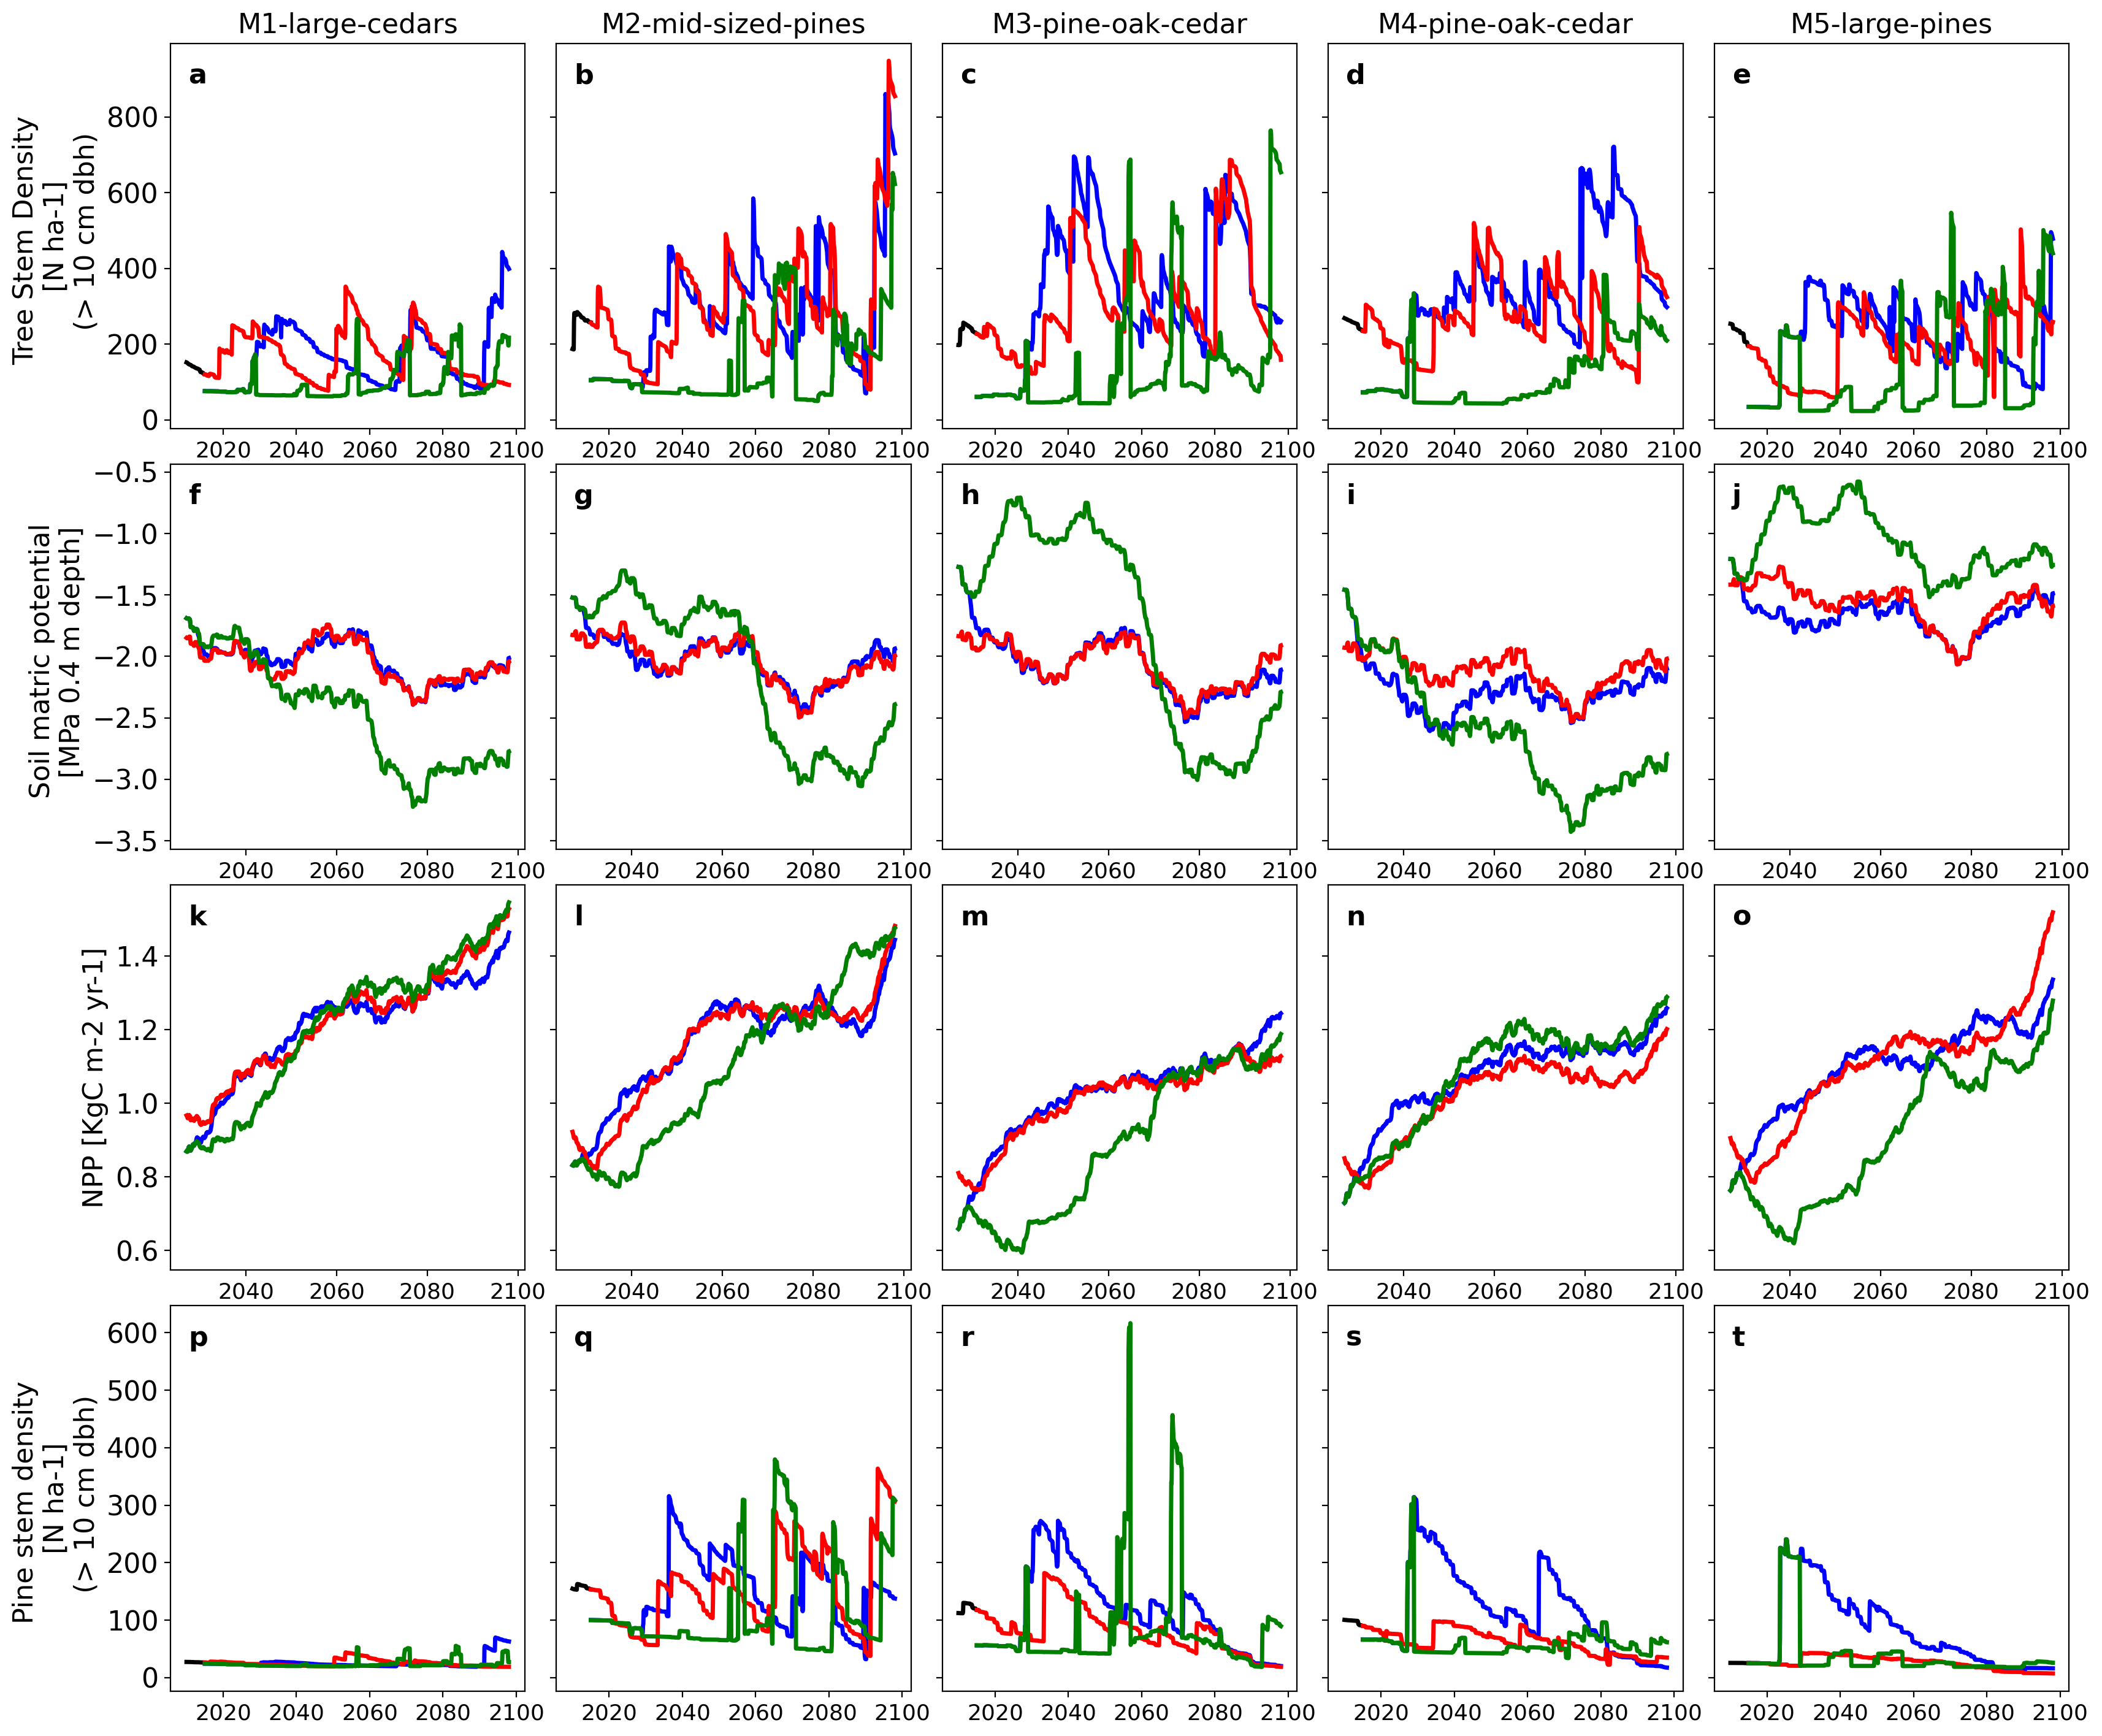

In [46]:
misc = ['TreeStemD','SMP','NPP','StemD10_pine']
compare_ts(full_ts,misc ,[1,2,3,4,5],"2010-01-01","2098-01-01",add_obs = False, figName = "smp-stem-npp",saveFig=True)

### Get change metrics

In [13]:
def get_val_on_date(df,var,date):
    treatments = df.loc[df['Date'] == date_convert(date)]['group'].to_numpy()
    values = df.loc[df['Date'] == date_convert(date)][var].to_numpy()
    return treatments,values

def ts_diff(df,var,tag,start_date,end_date):
    df = df.copy()
    df = df.loc[df['harmonized_tag'] == tag]

    treatments_start,start_values = get_val_on_date(df,var,start_date)
    
    treatments_end,end_values = get_val_on_date(df,var,end_date)
    
    if np.array_equal(treatments_start, treatments_end):
       
        absolute_change = end_values - start_values
        percent_change = (absolute_change / start_values) * 100
        out = pd.DataFrame({'scenario':treatments_start,
                            'start_val':start_values,
                            'end_val':end_values,
                            'abs_change':absolute_change,
                            'pct_change':percent_change,
                            'var':var,
                            'tag':tag})
        return out
    else:
        print('Caution, dims dont match')
        absolute_change = end_values - start_values
        percent_change = (absolute_change / start_values) * 100
        start_values = [start_values] * len(end_values)
        start_values = [s.item() for s in start_values]
        out = pd.DataFrame({'scenario':treatments_end,
                            'start_val':start_values,
                            'end_val':end_values,
                            'abs_change':absolute_change,
                            'pct_change':percent_change,
                            'var':var,
                            'tag':tag})
        
        return out

pd.set_option('display.float_format', '{:.4f}'.format) 
tags = [1,2,3,4,5]
change_df = pd.DataFrame()
for v in experimental_metrics:
    for t in tags:
        tmp = ts_diff(full_ts,v,t,'2016-12-01','2097-12-31')
        print(tmp)
        change_df = pd.concat([change_df,tmp],axis = 0)

change_df

Caution, dims dont match


ValueError: operands could not be broadcast together with shapes (0,) (3,) 

In [ ]:
full_ts

In [ ]:
change_df

In [ ]:
change_df

In [ ]:
change_df.loc[change_df['scenario'] == "single_treatment"]

### Get ensemble mean

In [ ]:
def ts_mean(df,var,tags,start_date,end_date):
    df = df.copy()
    df = df.loc[df['harmonized_tag'].isin(tags)]
    df = df.loc[( df['Date'] >= date_convert(start_date) ) & (df['Date'] <= date_convert(end_date) )]
    print(var,":", df[var].mean())

metrics = ['Burned_area','TreeStemD','BA_conifer','BA_oak','Pct_shrub_cover_canopy']#,'Pct_shrub_cover']

for v in metrics:
    ts_mean(full_ts,v,[1,2,3,4,5],'1840-01-01','1869-01-01')

In [ ]:
benchmarking_ts

## View simple figures

In [ ]:
def make_fig(df,x_var,y_var,tag = "all",group = "harmonized_tag"):
    if tag == "all":
        print("Using all tags")
    else:
        df = df.loc[df['harmonized_tag'] == tag]
    plt.rc('font', size=12)
    # Create a figure and an axes object
    fig, ax = plt.subplots()

    if group != None:
        # Group the data by the 'group' column and plot each group
        for name, group in df.groupby(group):
            ax.plot(group[x_var], group[y_var], label=name)

    else:
        print("need group")
        return
    # Add a legend to the plot
    ax.legend(title = "Member")
    ax.set_ylabel(vln[y_var])

    if y_var == "Burned_area":
        ax.set_ylim((0,20))
    
    # Show the plot
    plt.show()

In [ ]:
ts.loc[ts['harmonized_tag'] == 2][['Date','TreeStemD']].sort_values('Date')

In [ ]:
metrics = ['BA_conifer','BA_pine','BA_cedar','BA_fir',
           'BA_oak','Pct_shrub_cover_canopy','Pct_shrub_cover',
           'Burned_area','AWFI','Pct_high_severity_2600']

metrics = ['BA_conifer','Combustible_fuel','TreeStemD',
           'Burned_area','AWFI','Pct_high_severity_2600']

ts = pd.concat([f1870_2015_ts,SSP2_continuous_treatment],axis = 0)

for metric in metrics:
    make_fig(ts,'Date',metric)

## Benchmarking results

Criteria for PEAS structure

* There should be at least 5 trees ha-1 larger than 40 cm dbh
* There should be at least 5 percent total shrub cover
* Pine should not be failing
* There should be no more than 2 pfts failing
* AGB should be at least 2 Kg of Carbon per m2
* Burned area should be between 1 and 11 percent per year (this is the range in Williams+ 2023 and Mallek+ and then I added +- 2 perecnt)
* Percent of fires burning at high severity (3500 kw m-1) should be 20% (Note the actual range is estimated to be 1-6, but using this exact range would cull too many parameters)

Criteria for fire response

* Less burned area
* More severe fire
* Increased tree stem density




## There were 15 ensemble members passing the criteria

In [ ]:
ninst_passing = len(ts_sup_data['inst_tag'].unique())
print(ninst_passing)

## Ensemble is within the range of observations for some key variables, but variability among ensemble members is high
* Large variation among ensemble members for fire regime, conifer basal area, and shrub cover

In [ ]:
make_ts_fig(ts_sup_data,vars_to_plot = ['Burned_area','Pct_high_severity_3500','BA_conifer','Pct_shrub_cover_canopy'],start_date = "1820-01-01",end_date="2020-01-01")

In [ ]:
make_ts_fig(ts_sup_data,vars_to_plot = ['Combustible_fuel'],start_date = "1820-01-01",end_date="1869-01-01")

## ... But the size class distribution is wrong

See note book called "fire_bug_fix" to see how this was fixed.

In [ ]:
PEAS_011824_scls_dist_df = esm_tools.get_size_class_distribution(PEAS_011824,years=list(range(1869,1870)))

sns.boxplot(x='size_class', y='density', data=PEAS_011824_scls_dist_df)

# Adding titles and labels (optional)
plt.title('Conifer size class distribution')
plt.xlabel('Size Class [cm dbh]', fontsize = 12)
plt.ylabel('Density [N ha-1]', fontsize = 12)


# Display the plot
plt.show()

## Temp: checking TS for postOakFix

In [ ]:
a.Date[0]

In [ ]:
path_to_files = '/glade/work/adamhb/processed_output/CZ2_equilibrium_700yrs_042524_01_-17e2acb6a_FATES-1449c787'
paths = glob.glob(os.path.join(path_to_files,"ts_*"))

#print(paths)
ts_tmp = pd.DataFrame()
for f in paths:
    tmp = load_processed_data(f,tags = ['0011', '0024', '0048', '0054', '0064', '0065', '0067', '0092'])
    ts_tmp = pd.concat([ts_tmp,tmp.reset_index()],axis = 0)

In [ ]:
mean_burned_area = ts_tmp[ts_1980_2015]['Burned_area'].mean()
mean_burned_area

In [ ]:
ts_1980_2015 = ts_tmp['Date'] > datetime(1980,1,1)
ts_tmp[ts_1980_2015].groupby('inst_tag').mean()['Burned_area']
#ts_tmp[ts_1980_2015].groupby('inst_tag')['Burned_area'].plot()

In [ ]:
ts_tmp

In [ ]:
ts_0011 = ts_tmp.loc[(ts_tmp['inst_tag'] == '0011') & (ts_tmp['Date'] > datetime(1618, 1, 1)) & (ts_tmp['Date'] < datetime(1870, 1, 1))]
ts_0011_after_logging = ts_tmp.loc[(ts_tmp['inst_tag'] == '0011') & (ts_tmp['Date'] > datetime(1870, 1, 1)) & (ts_tmp['Date'] < datetime(1870, 8, 1))]

In [ ]:
plt.plot(ts_0011['BA_conifer'])

In [ ]:
plt.plot(ts_0011_after_logging['BA_conifer'])

In [ ]:
make_ts_fig(ts_tmp,
            vars_to_plot = ['Burned_area','Pct_high_severity_3500','BA_conifer','Pct_shrub_cover_canopy'],
            start_date = "1559-01-01",
            end_date="2015-01-01", tag_numbers=['0011', '0024', '0048', '0054', '0064', '0065', '0067', '0092'])

## Fixing the fire bug dramatically reduced fire

* PHS 1700 could be a better metric
* Therefore, the shrub cover went way down
* Combustible fuel went way down

In [ ]:
make_ts_fig(fire_bug_fix_data,['Burned_area', 'Pct_high_severity_3500', 'Pct_high_severity_1700', 'AGCD', 'BA_conifer', 'Pct_shrub_cover_canopy',
                               'VCD', 'Pct_conifer_cover_canopy', 'Pct_oak_cover_canopy', 'Pct_pine_cover_canopy', 'Pct_cedar_cover_canopy',
                               'Pct_fir_cover_canopy', 'BA_pine', 'BA_cedar', 'BA_fir', 'BA_oak', 'TreeStemD', 'Combustible_fuel', 'NPP',
                               'SMP', 'StemD10_pine'],start_date = "1840-01-01",end_date="1869-01-01", add_obs=False)

## Fire bug fix with double nignitions

In [ ]:
tags = np.array([2, 8, 14, 15, 22, 24, 25, 26, 30, 33, 46, 48, 50, 51, 52]) - 1
tags_with_double_nignition = np.array(list(range(55,109)))
tags_with_double_nignition_interest = tags_with_double_nignition[tags]
tags_with_double_nignition_interest

In [ ]:
make_ts_fig(fire_bug_fix_data,['Burned_area', 'Pct_high_severity_3500', 'Pct_high_severity_1700', 'AGCD', 'BA_conifer', 'Pct_shrub_cover_canopy',
                               'VCD', 'Pct_conifer_cover_canopy', 'Pct_oak_cover_canopy', 'Pct_pine_cover_canopy', 'Pct_cedar_cover_canopy',
                               'Pct_fir_cover_canopy', 'BA_pine', 'BA_cedar', 'BA_fir', 'BA_oak', 'TreeStemD', 'Combustible_fuel', 'NPP',
                               'SMP', 'StemD10_pine'],start_date = "1840-01-01",end_date="1869-01-01", add_obs=False,tag_numbers=tags_with_double_nignition_interest)

### Ensemble mean variable values and changes in response to suppression

In [ ]:
df_sup = metrics_diff(met_early21st_sup,met_peas)
df_sup.loc[['Burned_area','Pct_high_severity_3500','BA_conifer','Pct_shrub_cover_canopy',
            'VCD','Pct_conifer_cover_canopy','TreeStemD','BA_pine','BA_cedar','BA_fir','BA_oak']]

### Other forest responses to fire suppression

In [ ]:
make_ts_fig(ts_sup_data,vars_to_plot=['BA_pine','BA_cedar','BA_fir','BA_oak','TreeStemD'],start_date = "1820-01-01",end_date="2020-01-01")

## No suppression with PEAS ignition rate results in too much future fire and conifers die out

Therefore, for future scenarios we use the same ignition rate as the suppressed forest scenario (fire thresh and the forest structure are still "restored")

In [ ]:
make_ts_fig(ts_HF_data,vars_to_plot = ['Burned_area','Pct_high_severity_3500','BA_conifer'],start_date = "1820-01-01",end_date="2098-01-01")

## Future changes in functional composition

The suppression scenario shows a decrease in conifer cover of 13.5% +- 21 (90% cover to 77% cover) between 2015 and 2098. This corresponds to changes in basal area of 49 m2 ha-1 to 33 m2 ha-1 (delta of 16 +-11). The suppression scenario showed an increase in shrub cover 7% +- 17 (3 to 10). 

The restored forest scenario showed an increase in conifer cover of 16% +- 30 (62 to 78) and a decrease in shrub cover of 20% +- 29 (30 to 10). The conifer change in terms of basal area is an increase of 7.15 +- 15 m2 ha-1 of basal area.

### Changes in % cover

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data],
           vars_to_plot = ['Pct_conifer_cover_canopy','Pct_shrub_cover_canopy','Pct_oak_cover_canopy',
                           'Pct_pine_cover_canopy','Pct_cedar_cover_canopy','Pct_fir_cover_canopy'],zeroto100=True
          )

### Changes in cover (% and basal area)

This was the main figure.

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data],
           vars_to_plot = ['Burned_area','Pct_high_severity_3500',
                           'Pct_conifer_cover_canopy','BA_conifer',
                           'Pct_shrub_cover_canopy','Pct_oak_cover_canopy'],zeroto100=True)

### Changes in tree basal area

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data],
           vars_to_plot = ['BA_pine','BA_cedar','BA_fir','BA_oak'],zeroto100=True)

### Quantification of changes in functional composition

##### Suppression

In [ ]:
df_sup = metrics_diff(met_late_21st_sup,met_early21st_sup)
df_sup.loc[['VCD','Pct_conifer_cover_canopy','BA_conifer','Pct_shrub_cover_canopy']]

##### Restored

In [ ]:
df_HF = metrics_diff(met_late_21st_HFig105,met_early21st_HF)
df_HF.loc[['VCD','Pct_conifer_cover_canopy','BA_conifer','Pct_shrub_cover_canopy']]

### The effects of increasing CO2
The suppression scenario with future climate change but without increasing CO2 projects a net reduction in vegetation carbon of 8.5 kg C m-2 +- 3.7 (40% more vegetation carbon is lost without transient CO2). 25 m2 ha-1 of conifer basal area is lost without transient CO2 (50% more conifer basal area is lost without transient CO2).A reduction of 19 cover points (40% more conifer cover is lost). 

The restored forest scenario gains less carbon without CO2 fertilization. 3.5 to -12.
The restored forest scenario with future climate change but without increasing CO2 projects a net reduction of 2 m2 ha-1 of conifer basal area (mean delta went from positive to negative; 16 to -2). Projects a mean reduction in conifer cover of 4% (reduction of 70%).
Shrubs do better with constant CO2 in both scenarios. 7 % increase to a 15 % increase in suppression.-20 % decrease to -6 % decrease in restored forest.

##### Suppression

In [ ]:
df_sup_const_CO2 = metrics_diff(met_late_21st_sup_const_CO2,met_early21st_sup)
df_sup_const_CO2.loc[['VCD','Pct_conifer_cover_canopy','BA_conifer','Pct_shrub_cover_canopy']]

##### Restored

In [ ]:
df_HF_const_CO2 = metrics_diff(met_late_21st_HFig105_const_CO2,met_early21st_HF)
df_HF_const_CO2.loc[['VCD','Pct_conifer_cover_canopy','BA_conifer','Pct_shrub_cover_canopy']]

### Future changes in fire regime

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data],
           vars_to_plot = ['Burned_area','Pct_high_severity_3500','Combustible_fuel']
          )

## Vital rates

In [ ]:
per_cap_mort_vars = ['mort_pine_fire_per_cap','mort_cedar_fire_per_cap',
                     'mort_pine_cstarve_per_cap','mort_cedar_cstarve_per_cap',
                     'mort_pine_hydr_per_cap','mort_cedar_hydr_per_cap']

per_cap_fire_mort_vars = ['mort_pine_fire_per_cap','mort_cedar_fire_per_cap',
                     'mort_fir_fire_per_cap','mort_oak_fire_per_cap',
                     'mort_shrub_fire_per_cap']

per_cap_cstarve_mort_vars = ['mort_pine_cstarve_per_cap','mort_cedar_cstarve_per_cap',
                     'mort_fir_cstarve_per_cap','mort_oak_cstarve_per_cap',
                     'mort_shrub_cstarve_per_cap']

per_cap_hydr_mort_vars = ['mort_pine_hydr_per_cap','mort_cedar_hydr_per_cap',
                     'mort_fir_hydr_per_cap','mort_oak_hydr_per_cap',
                     'mort_shrub_hydr_per_cap']

#### Total mortality by size class

In [ ]:
get_fire_mort(HF_case_early_21st,[1965,2015],1,dbh_min = 0, var = 'FATES_MORTALITY_CANOPY_SZAP')

#### Fire mort

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data], vars_to_plot = per_cap_fire_mort_vars,mysharey=True)

#### Carbon starvation

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data], vars_to_plot = per_cap_cstarve_mort_vars,mysharey=True)

#### Hydrauilic failure

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data], vars_to_plot = per_cap_hydr_mort_vars,mysharey=True)

#### Recruitment rates

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data], vars_to_plot = ['Rec_pine','Rec_cedar','Rec_fir',
                                                                                                               'Rec_shrub','Rec_oak'])

## Future carbon fluxes

FATES projects that suppressed forests will experience a net reduction in vegetation carbon density of 6.5 Kg C m-2 (+- 6.2 SD) between 2015 and 2098 under SSP3. Restored forests will experience a net gain in vegetation carbon density of 3.5 Kg C m-2 (+-8.5 SD). A mean resilience gain (flux differential) of 10 Kg (+- 10.7) C m-2. See propagation of uncertainties below for calculation of the 10.7.

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data], vars_to_plot = ['VCD'])

#### Suppression

In [ ]:
df_sup = metrics_diff(met_late_21st_sup,met_early21st_sup)
print("VCD")
df_sup.loc['VCD']

#### Restored

In [ ]:
df_HF = metrics_diff(met_late_21st_HFig105,met_early21st_HF)
print("VCD")
df_HF.loc['VCD']

#### Propagation of uncertainties for resilience gain

In [ ]:
#sqrt(uncertainty1^ + uncertainty2^2)

import math
math.sqrt(6.5**2 + 8.5**2)

math.sqrt(30**2 + 21**2)

## Stand structure

### Fields for stand structure

In [ ]:
fields = [
          #have on to import these dimensions
          #'FATES_SEED_PROD_USTORY_SZ',
          'FATES_VEGC_AP',
          #patches and cohorts
          'FATES_NPATCHES',
          #'FATES_PATCHAREA_AP','FATES_CANOPYAREA_AP',
          'FATES_NCOHORTS','FATES_NPATCH_AP',
          #structure
          #'FATES_LAI_AP',
          #density
          'FATES_NPLANT_PF',
          'FATES_NPLANT_SZAPPF',
          'FATES_NPLANT_SZPF',
          'FATES_NPLANT_ACPF',
          #'FATES_NPLANT_CANOPY_SZPF',
          #'FATES_NPLANT_USTORY_SZPF',
          #basal area
          'FATES_BASALAREA_SZPF',
          #crown_area
          #'FATES_CANOPYCROWNAREA_PF',
          #'FATES_CANOPYCROWNAREA_APPF',
          #'FATES_CANOPYAREA_HT',
          #'FATES_CROWNAREA_CLLL',
          #'FATES_CROWNAREA_PF',
          #biomass
          #'FATES_VEGC_PF','FATES_VEGC_AP','FATES_VEGC_ABOVEGROUND','FATES_VEGC_ABOVEGROUND_SZPF',
          #growth
          #'FATES_DDBH_SZPF',
          #'FATES_DDBH_CANOPY_SZAP','FATES_DDBH_USTORY_SZAP',
          #mortality
          #'FATES_MORTALITY_PF',
          'FATES_MORTALITY_CANOPY_SZ',
          #'FATES_MORTALITY_USTORY_SZAP',
          #'FATES_MORTALITY_BACKGROUND_SZPF','FATES_MORTALITY_HYDRAULIC_SZPF','FATES_MORTALITY_CSTARV_SZPF',
          #'FATES_MORTALITY_IMPACT_SZPF',
          #'FATES_MORTALITY_FIRE_SZPF','FATES_MORTALITY_CROWNSCORCH_SZPF',
          #'FATES_MORTALITY_CANOPY_SZ','FATES_MORTALITY_USTORY_SZ',
          #'FATES_MORTALITY_SENESCENCE_SZPF',
          #seed production and recruitment
          #'FATES_SEED_PROD_USTORY_SZ','FATES_SEED_PROD_CANOPY_SZ',
          #'FATES_SEEDS_IN',
          #'FATES_SEED_BANK',
          #'FATES_SEEDBANK_PF',
          #'FATES_SEED_ALLOC_SZPF',
          'FATES_RECRUITMENT_PF',
          #GPP and NPP
          #'FATES_GPP','FATES_GPP_SZPF',
          #'FATES_NPP_PF','FATES_NPP_SZPF',
          #'FATES_AUTORESP_SZPF','FATES_MAINTAR_SZPF',
          #physical environment
          #Light
          # 'FATES_LAISUN_Z_CLLL','FATES_LAISHA_Z_CLLL',
          # 'FATES_LAISUN_Z_CLLLPF','FATES_LAISHA_Z_CLLLPF',
          # 'FATES_PARSUN_Z_CLLLPF','FATES_PARSHA_Z_CLLLPF',
          # 'FATES_PARPROF_DIR_CLLL','FATES_PARPROF_DIF_CLLL',
          # 'FATES_PARPROF_DIF_CLLLPF','FATES_PARPROF_DIR_CLLLPF',
          #Litter
          #'FATES_CWD_ABOVEGROUND_DC',
          #'FATES_FUEL_AMOUNT',
          #CLM
          #'QVEGT','QVEGE','QSOIL','TLAI','TBOT','RAIN','QBOT','Q2M',
          #'BTRAN',
          #H20
          'SMP'#,
          #allocation
          #'FATES_STOREC_CANOPY_SZPF','FATES_STOREC_USTORY_SZPF',
          #fire
          #'FATES_BURNFRAC','FATES_IGNITIONS','FATES_FIRE_INTENSITY_BURNFRAC',
          #'FATES_FUEL_BULKD','FATES_FUEL_SAV',
          # 'FATES_DISTURBANCE_RATE_FIRE',
          # 'FATES_FUEL_AMOUNT_AP',
          # 'FATES_FIRE_INTENSITY_BURNFRAC_AP',
          # 'FATES_BURNFRAC_AP',
          # 'FATES_FUEL_AMOUNT_APFC',
          # 'FATES_FUEL_AMOUNT',
          # 'FATES_FDI',
          # 'FATES_FIRE_INTENSITY',
          # 'FATES_FUELCONSUMED',
          # 'FATES_NESTEROV_INDEX',
          # 'FATES_MORTALITY_CROWNSCORCH_SZPF',
          # 'FATES_SCORCH_HEIGHT_APPF','FATES_FUEL_MEF',
          # 'FATES_FUEL_EFF_MOIST','FATES_FUEL_MOISTURE_FC','FATES_ROS'
          # 'FATES_MORTALITY_FIRE_CFLUX_PF'
          ]

### Stand structure in 2015

#### Suppression case

In [ ]:
sup_2015_scls = get_size_class_distribution(sup_case_early_21st,[2014,2015])

#### Restored forest case

In [ ]:
HF_2015_scls = get_size_class_distribution(HF_case_early_21st,[2014,2015])

### Stand structure in 2098

#### Suppressed forest

In [ ]:
sup_late_21st_stand_structure = get_size_class_distribution(sup_case_late_21st,[2097,2098])

### Restored forest

In [ ]:
HF_late_21st_stand_structure = get_size_class_distribution(HF_case_late_21st,[2097,2098])

#### Treatment test

This test 

In [ ]:
untreated_case = 'supIg105_020224-2015-2098_-17e2acb6a_FATES-5b076b69'
treated_case = 'supIg105_treated_041124-2015-2098-2015-2098_-17e2acb6a_FATES-1449c787'
scd_untreated = get_size_class_distribution(untreated_case,[2016,2018],metric="ba")
#get_size_class_distribution(treated_case,[2016,2018])

In [ ]:
scd_treated = get_size_class_distribution(treated_case,[2016,2018],metric="ba",plot = False)

In [ ]:
#plt.rc('font', size=12)
# Creating the box and whisker plot
sns.boxplot(x='size_class', y='density', data=scd_treated)

# Adding titles and labels (optional)
plt.title('Conifer basal area distribution')
plt.xlabel('Size Class [cm dbh]')
plt.ylabel('Basal area [m2 ha-1]')
plt.ylim((0,30))

# Display the plot
plt.show()

In [ ]:
#plt.rc('font', size=12)
# Creating the box and whisker plot
sns.boxplot(x='size_class', y='density', data=scd_untreated)

# Adding titles and labels (optional)
plt.title('Conifer basal area distribution')
plt.xlabel('Size Class [cm dbh]')
plt.ylabel('Basal area [m2 ha-1]')
plt.ylim((0,30))

# Display the plot
plt.show()

In [ ]:
#plt.rc('font', size=12)
# Creating the box and whisker plot
sns.boxplot(x='size_class', y='density', data=scd_untreated)

# Adding titles and labels (optional)
plt.title('Conifer size class distribution')
plt.xlabel('Size Class [cm dbh]')
plt.ylabel('Density [N ha-1]')
plt.ylim((0,100))

# Display the plot
plt.show()

In [ ]:
scd_treated = get_size_class_distribution(treated_case,[2016,2018])

In [ ]:
#plt.rc('font', size=12)
# Creating the box and whisker plot
sns.boxplot(x='size_class', y='density', data=scd_treated)

# Adding titles and labels (optional)
plt.title('Conifer size class distribution')
plt.xlabel('Size Class [cm dbh]')
plt.ylabel('Density [N ha-1]')
plt.ylim((0,100))

# Display the plot
plt.show()

## Fire mortality

#### Successul ignitions

In [ ]:
def get_successful_ignitions(case_name,years,var = 'FATES_IGNITIONS'):
    tag_numbers = [2, 4, 7, 19, 30, 43, 44, 49, 51]
    #tag_numbers = [2,  8, 14, 15, 22, 24, 25, 26, 30, 33, 46, 48, 50, 51, 52]
    inst_tags = esm_tools.inst_to_tag(tag_numbers) 
    output = pd.DataFrame()

    mean_successful_ignitions = []
    for inst_tag in inst_tags:
        ds = esm_tools.load_fates_output_data(model_output_root='/glade/derecho/scratch/adamhb',
                                    case_name = case_name,
                                    years = years,
                                    fields = ['FATES_IGNITIONS'],
                                    inst_tag = inst_tag,
                                    manual_path = None)
        
        tmp = ds[var].mean(dim = "time").values * 3.154e13
        mean_successful_ignitions.append(tmp)
    return mean_successful_ignitions

In [ ]:
#successful_ignitions = get_successful_ignitions(sup_case_early_21st,[1960,2000],var = 'FATES_IGNITIONS')
successful_ignitions = get_successful_ignitions('CZ2_equilibrium_011824_-17e2acb6a_FATES-5b076b69',[1800,1869],var = 'FATES_IGNITIONS')

In [ ]:
successful_ignitions

In [ ]:
nign = np.array([2.50288919296338,
 0.136548100249566,
 0.711298623200441,
 0.835443985502639,
 0.262196914182938,
 0.428518562275885,
 1.43964184982846,
 1.54531759296711,
 0.757860616193905])

ign = np.array(successful_ignitions)

pd.DataFrame({'n':nign,'suc_ig':ign, 'rate':ign/nign})

### Fields for fire mortality

#### Fields

In [ ]:
fields = [
          #have on to import these dimensions
          #'FATES_SEED_PROD_USTORY_SZ',
          'FATES_VEGC_AP',
          #patches and cohorts
          'FATES_NPATCHES',
          #'FATES_PATCHAREA_AP','FATES_CANOPYAREA_AP',
          'FATES_NCOHORTS','FATES_NPATCH_AP',
          #structure
          #'FATES_LAI_AP',
          #density
          'FATES_NPLANT_PF',
          'FATES_NPLANT_SZAPPF',
          'FATES_NPLANT_SZPF',
          'FATES_NPLANT_ACPF',
          #'FATES_NPLANT_CANOPY_SZPF',
          #'FATES_NPLANT_USTORY_SZPF',
          #basal area
          #'FATES_BASALAREA_SZPF',
          #crown_area
          #'FATES_CANOPYCROWNAREA_PF',
          #'FATES_CANOPYCROWNAREA_APPF',
          #'FATES_CANOPYAREA_HT',
          #'FATES_CROWNAREA_CLLL',
          #'FATES_CROWNAREA_PF',
          #biomass
          #'FATES_VEGC_PF','FATES_VEGC_AP','FATES_VEGC_ABOVEGROUND','FATES_VEGC_ABOVEGROUND_SZPF',
          #growth
          #'FATES_DDBH_SZPF',
          #'FATES_DDBH_CANOPY_SZAP','FATES_DDBH_USTORY_SZAP',
          #mortality
          #'FATES_MORTALITY_PF',
          'FATES_MORTALITY_CANOPY_SZ',
          #'FATES_MORTALITY_USTORY_SZAP',
          'FATES_MORTALITY_BACKGROUND_SZPF',
          'FATES_MORTALITY_HYDRAULIC_SZPF',
          'FATES_MORTALITY_CSTARV_SZPF',
          #'FATES_MORTALITY_IMPACT_SZPF',
          'FATES_MORTALITY_FIRE_SZPF','FATES_MORTALITY_CROWNSCORCH_SZPF','FATES_MORTALITY_CANOPY_SZAP',
          #'FATES_MORTALITY_CAMBIALBURN_SZPF',
          #'FATES_MORTALITY_CANOPY_SZ','FATES_MORTALITY_USTORY_SZ',
          'FATES_MORTALITY_SENESCENCE_SZPF',
          #seed production and recruitment
          #'FATES_SEED_PROD_USTORY_SZ','FATES_SEED_PROD_CANOPY_SZ',
          #'FATES_SEEDS_IN',
          #'FATES_SEED_BANK',
          #'FATES_SEEDBANK_PF',
          #'FATES_SEED_ALLOC_SZPF',
          'FATES_RECRUITMENT_PF',
          #GPP and NPP
          #'FATES_GPP','FATES_GPP_SZPF',
          #'FATES_NPP_PF','FATES_NPP_SZPF',
          #'FATES_AUTORESP_SZPF','FATES_MAINTAR_SZPF',
          #physical environment
          #Light
          # 'FATES_LAISUN_Z_CLLL','FATES_LAISHA_Z_CLLL',
          # 'FATES_LAISUN_Z_CLLLPF','FATES_LAISHA_Z_CLLLPF',
          # 'FATES_PARSUN_Z_CLLLPF','FATES_PARSHA_Z_CLLLPF',
          # 'FATES_PARPROF_DIR_CLLL','FATES_PARPROF_DIF_CLLL',
          # 'FATES_PARPROF_DIF_CLLLPF','FATES_PARPROF_DIR_CLLLPF',
          #Litter
          #'FATES_CWD_ABOVEGROUND_DC',
          #'FATES_FUEL_AMOUNT',
          #CLM
          #'QVEGT','QVEGE','QSOIL','TLAI','TBOT','RAIN','QBOT','Q2M',
          #'BTRAN',
          #H20
          'SMP'#,
          #allocation
          #'FATES_STOREC_CANOPY_SZPF','FATES_STOREC_USTORY_SZPF',
          #fire
          #'FATES_BURNFRAC','FATES_IGNITIONS','FATES_FIRE_INTENSITY_BURNFRAC',
          #'FATES_FUEL_BULKD','FATES_FUEL_SAV',
          # 'FATES_DISTURBANCE_RATE_FIRE',
          # 'FATES_FUEL_AMOUNT_AP',
          # 'FATES_FIRE_INTENSITY_BURNFRAC_AP',
          # 'FATES_BURNFRAC_AP',
          # 'FATES_FUEL_AMOUNT_APFC',
          # 'FATES_FUEL_AMOUNT',
          # 'FATES_FDI',
          # 'FATES_FIRE_INTENSITY',
          # 'FATES_FUELCONSUMED',
          # 'FATES_NESTEROV_INDEX',
          # 'FATES_MORTALITY_CROWNSCORCH_SZPF',
          # 'FATES_SCORCH_HEIGHT_APPF','FATES_FUEL_MEF',
          # 'FATES_FUEL_EFF_MOIST','FATES_FUEL_MOISTURE_FC','FATES_ROS'
          # 'FATES_MORTALITY_FIRE_CFLUX_PF'
          ]

In [ ]:
# HF_case_early_21st = 'HF_020424-1951-2020_-17e2acb6a_FATES-5b076b69'
# sup_case_early_21st = 'supIg105_020224-1951-2020_-17e2acb6a_FATES-5b076b69'
# sup_case_late_21st = 'supIg105_020224-2015-2098_-17e2acb6a_FATES-5b076b69'
# HF_case_late_21st = 'HF_ig105_021324-2015-2098_-17e2acb6a_FATES-5b076b69'

#### Per cap mort retored forest 2015

In [ ]:
get_fire_mort(HF_case_early_21st,[1985,2015],0,dbh_min = 0, var = 'FATES_MORTALITY_HYDRAULIC_SZPF')

In [ ]:
get_fire_mort(HF_case_early_21st,[1985,2015],1,dbh_min = 0, var = 'FATES_MORTALITY_CSTARV_SZPF')

In [ ]:
get_fire_mort(HF_case_early_21st,[1985,2015],0,dbh_min = 0, var = 'FATES_MORTALITY_FIRE_SZPF')

In [ ]:
get_fire_mort(HF_case_early_21st,[1985,2015],1,dbh_min = 0, var = 'FATES_MORTALITY_SENESCENCE_SZPF')

#### per cap sup forest 2015

In [ ]:
get_fire_mort(sup_case_early_21st,[1985,2015],0,dbh_min = 0, var = 'FATES_MORTALITY_FIRE_SZPF')

#### per cap sup 2098

In [ ]:
get_fire_mort(sup_case_late_21st,[2068,2098],0,dbh_min = 0, var = 'FATES_MORTALITY_FIRE_SZPF')

#### per cap restored 2098

In [ ]:
get_fire_mort(HF_case_late_21st,[2068,2098],0,dbh_min = 0, var = 'FATES_MORTALITY_FIRE_SZPF')

## Physical Environment

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data], vars_to_plot = ['SMP'])

#### Treatment test

## NPP

In [ ]:
eq = pd.read_csv('/glade/work/adamhb/processed_output_cheyenne/CZ2_equilibrium_110323_and_110523/CZ2_equilibrium_110323_and_110523.csv')

In [ ]:
eq['NPP'].hist()

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data], vars_to_plot = ['NPP'])

In [ ]:
compare_ts([ts_sup_data,ts_HFig105_data,ts_supIg105_const_CO2_data,ts_HFig105_const_CO2_data], vars_to_plot = ['TreeStemD'])

## GPP

## Ensemble histograms of PEAS metrics

In [ ]:
# for v in obs_PEAS.keys():
#     HistModelObs(met_peas,obs_PEAS, v)

## Ensemble histograms of suppression metrics

In [ ]:
# for v in obs_SUP.keys():
#     HistModelObs(met_early21st_sup,obs_SUP, v)

In [ ]:
# ds = esm_tools.load_fates_output_data(model_output_root='/glade/derecho/scratch/adamhb',
#                                     case_name = 'supIg_0.25_051324-1870-1951_-17e2acb6a_FATES-1449c787',
#                                     years = list(range(1870,1920)),
#                                     fields = fields,
#                                     inst_tag = '0042',
#                                     manual_path = None)

In [ ]:
# a = pd.read_csv('/glade/work/adamhb/processed_output/supIg_0.25_051324/ts_1870-1995_0076.csv')
# filt = a['Burned_area']>0
# a.loc[filt]['Burned_area'].median()

In [ ]:
filt = ts['Burned_area'] > 0
filt2 = ts['Date'] > '1930-01-01'
ts.loc[filt & filt2].groupby('harmonized_tag')['Burned_area'].mean()

In [ ]:
# def compare_ts(ts_data,
#                vars_to_plot,
#                tags,
#                start_date = None,
#                end_date = None,
#                figName = "fig",
#                saveFig = False,
#                add_obs = True):

    
#     ts_data = ts_data.copy()

#     # Filter by date
#     if (start_date != None) & (end_date != None):
#         ts_data = ts_data.loc[(ts_data['Date'] >= date_convert(start_date)) & (ts_data['Date'] <= date_convert(end_date))]
    
#     # Filter by tag  
#     ts_data = ts_data.loc[ts_data['harmonized_tag'].isin(tags)]
#     ts_data_PHS = ts_data.dropna().copy()
#     groups = ts_data['group'].unique()
#     group_names_dict = {'pre-restoration':'pre-treatment','single_treatment':'single treatment','not_treated':'not treated','continuous_treatment':'continuous treatment'}
#     group_names = [group_names_dict[i] for i in groups]

    
#     # Calculate the number of rows needed for subplots
#     num_rows = (len(vars_to_plot) + my_num_cols - 1) // my_num_cols
    
#     # Years to add to timeline
#     year_1870 = datetime(1870, 1, 1)
#     year_PEAS_obs = datetime(1832, 1, 1)
#     year_EAS_obs = datetime(2014,1,1)
#     year_2015 = datetime(2015,1,1)
    
#     plt.rc('font', size=my_font_size)
    
#     # Create a figure with subplots
#     y_size_factor = 60/7
#     y_size = y_size_factor * num_rows
    
#     fig, axes = plt.subplots(num_rows, my_num_cols, figsize=(30, y_size), dpi=200)
#     axes = axes.flatten()
    
#     # Loop through each variable and create a subplot
#     for var_index, var in enumerate(vars_to_plot):
#         ax = axes[var_index]
#         fire_sev_var = ("Pct_high_sev" in var) | ("AWFI" in var)
#         for i,s in enumerate(groups):
            
#             if fire_sev_var:
#                 plot_data = get_mean_and_std_ts(ts_data_PHS,var,groups[i])
#                 #print(plot_data.info())
#                 #print(plot_data)
#                 plot_data['rolling_var'] = plot_data[var].rolling(window = 5).mean()
#                 ax.plot(plot_data['Date'], plot_data['rolling_var'], color=group_colors[i], linewidth = 3, linestyle=group_linetypes[i],label = group_names[i])
#                 if i < 2:
#                     ax.fill_between(plot_data['Date'], plot_data[var] - plot_data['std'], plot_data[var] + plot_data['std'], color=group_colors[i], alpha=0.06)
                
#                 #sns.lineplot(x="Date", y=var, units="harmonized_tag", data=ts_data_PHS, ax=ax, color = "grey", alpha = 0.2, estimator=None)
#             else:
#                 plot_data = get_mean_and_std_ts(ts_data,var,groups[i])
#                 if ('mort' in var) | ('SMP' in var) | ('NPP' in var) | ('Rec' in var):
#                     plot_data = add_running_mean_time_window(plot_data)
#                     print("adding running mean")
#                     return plot_data
#                 ax.plot(plot_data['Date'], plot_data[var], color=group_colors[i], linewidth = 3, linestyle=group_linetypes[i],label = group_names[i])
#                 if i < 2:
#                     ax.fill_between(plot_data['Date'], plot_data[var] - plot_data['std'], plot_data[var] + plot_data['std'], color=group_colors[i], alpha=0.06)
                
#                 #sns.lineplot(x="Date", y=var, units="harmonized_tag", data=ts_data, ax=ax, color = "grey", alpha = 0.2, estimator=None)

#         if add_obs == True:
#             if var in obs_PEAS.keys():
#                 ax.vlines(x=year_PEAS_obs, color="black", linestyle="-", linewidth = 10, 
#                           ymin = obs_PEAS[var][0], ymax = obs_PEAS[var][1], alpha = 0.8, label = "PEAS observations")
#             if var in obs_SUP.keys():        
#                 ax.vlines(x=year_EAS_obs, color="skyblue", linestyle="-", linewidth = 10,
#                           ymin = obs_SUP[var][0], ymax = obs_SUP[var][1], alpha = 0.8, label = "EAS observations")

#         ax.set_title(vln[var])
#         ax.set_ylabel(vln[var])
#         ax.set_xlabel("Year")
#         ax.xaxis.set_major_locator(mdates.YearLocator(base=15))
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
#         # Set plot title and labels
#         if var == "Burned_area":
#             ax.set_ylim(ymin=0)
        
#         if min(ts_data['Date']) < year_1870:
#             ax.axvline(x=year_1870, color="red", linestyle="--")
#         if max(ts_data['Date']) > year_2015:
#             ax.axvline(x=year_2015, color="green", linestyle="--")
    

#         # Add legend to first subplot
#         if var_index < 1:
#             ax.legend()
        
#     # Remove any empty subplots
#     for i in range(len(vln.keys()), num_rows * my_num_cols):
#         fig.delaxes(axes[var_index])
    
#     # Adjust layout
#     plt.tight_layout()

#     if saveFig == True:
#         figName = os.path.join(figOut,figName + '.pdf')
#         print(figName)
#         plt.savefig(figName)
    
#     plt.show()